In [2]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 13.1 MB/s eta 0:00:00a 0:00:01


In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk
from scipy.stats import kurtosis

# ==========================================
# 1. FILE CONFIGURATION
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)

#/kaggle/input/abp-dataset/measurements_oscillometric/measurements_oscillometric/o006/o006.initial.Supine_2.tsv

RELATIVE_FILE_PATH = os.path.join('measurements_oscillometric',
                                  'measurements_oscillometric',
                                  'o500',
                                  'o500.initial.Supine_2.tsv')
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

def load_abp_data(file_path):
    if not os.path.exists(file_path): return None
    return pd.read_csv(file_path, sep='\t')

# ==========================================
# 2. PROCESSING (Includes Highpass Fix)
# ==========================================
def get_sampling_rate(df):
    if len(df) < 2: return 125.0
    return 1.0 / np.mean(np.diff(df['t']))

def process_all_signals(df):
    fs = get_sampling_rate(df)
    print(fs)
    df_filt = df.copy()
    
    # ECG Processing (With Highpass for Baseline Removal)
    if 'ekg' in df.columns:
        # 1. Highpass (0.5 Hz) - CRITICAL for baseline wander
        sos_hp = signal.butter(1, 0.5, btype='highpass', fs=fs, output='sos')
        sig_hp = signal.sosfiltfilt(sos_hp, df['ekg'].values)
        
        # 2. Notch (50-70 Hz)
        sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
        sig_notch = signal.sosfiltfilt(sos_notch, sig_hp)
        
        # 3. Lowpass (40 Hz)
        sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=40, btype='lowpass', fs=fs, output='sos')
        sig_lp = signal.sosfiltfilt(sos_lp, sig_notch)
        
        # 4. Invert Check
        corrected_ecg, _ = nk.ecg_invert(sig_lp, sampling_rate=int(fs))
        df_filt['ekg'] = corrected_ecg
        
    # PPG Processing
    if 'optical' in df.columns:
        sos_bp = signal.butter(4, [0.5, 10], btype='bandpass', fs=fs, output='sos')
        df_filt['optical'] = signal.sosfiltfilt(sos_bp, df['optical'].values)
        
    return df_filt, fs

# ==========================================
# 3. ADVANCED METRICS EXTRACTION
# ==========================================
def analyze_segment_metrics(ecg_chunk, ppg_chunk, fs):
    """
    Returns a dictionary with exact metrics for ranking.
    """
    metrics = {'score': 0, 'reasons': []}
    
    # --- 1. ECG SCORING ---
    try:
        q_class = nk.ecg_quality(ecg_chunk, sampling_rate=fs, method="zhao2018")
        if q_class == 'Excellent': metrics['score'] += 5
        elif q_class == 'Barely acceptable': metrics['score'] += 2
    except: pass

    # Kurtosis (Higher = Sharper peaks = Better)
    metrics['ecg_kurtosis'] = kurtosis(ecg_chunk)

    # Variance Check (Lower penalty threshold)
    ecg_std = np.std(ecg_chunk)
    if ecg_std > 0.25: 
        metrics['score'] -= 10
        metrics['reasons'].append("HighVar")
    else:
        metrics['score'] += 2

    # --- 2. PPG SCORING ---
    try:
        # Get raw correlation value (0.0 to 1.0)
        q_temp = np.mean(nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="templatematch"))
        metrics['ppg_match_val'] = q_temp
        
        if q_temp > 0.85: metrics['score'] += 5
        elif q_temp > 0.6: metrics['score'] += 3
    except:
        metrics['ppg_match_val'] = 0.0

    return metrics

# ==========================================
# 4. FIND THE BEST SEGMENT (RANKING LOGIC)
# ==========================================
def find_best_segment(df, fs, duration_sec=8):
    window_samples = int(duration_sec * fs)
    step_samples = int(1.0 * fs) # 1 second step
    
    candidates = []
    
    print("Scanning and ranking segments...")
    
    for i in range(0, len(df) - window_samples, step_samples):
        # Extract Data
        ecg_c = df['ekg'].iloc[i : i+window_samples].values
        ppg_c = df['optical'].iloc[i : i+window_samples].values
        
        # Analyze
        m = analyze_segment_metrics(ecg_c, ppg_c, fs)
        
        # Store Candidate
        candidate = {
            'start_idx': i,
            'end_idx': i+window_samples,
            'time_start': df['t'].iloc[i],
            'total_score': m['score'],
            'ppg_quality': m['ppg_match_val'], # Tie-breaker 1
            'ecg_sharpness': m['ecg_kurtosis'] # Tie-breaker 2
        }
        
        # Only keep decent candidates to save memory
        if m['score'] > 0:
            candidates.append(candidate)
            
    # --- SORTING LOGIC ---
    # 1. Sort by Total Score (Descending)
    # 2. Then by PPG Quality (Descending)
    # 3. Then by ECG Kurtosis (Descending)
    sorted_candidates = sorted(
        candidates, 
        key=lambda x: (x['total_score'], x['ppg_quality'], x['ecg_sharpness']), 
        reverse=True
    )
    
    if not sorted_candidates:
        print("No valid segments found.")
        return None
        
    best = sorted_candidates[0]
    print(f"\nWINNER FOUND!")
    print(f"Time: {best['time_start']:.1f}s")
    print(f"Score: {best['total_score']}")
    print(f"PPG Match: {best['ppg_quality']:.4f} (Perfect=1.0)")
    print(f"ECG Kurtosis: {best['ecg_sharpness']:.2f}")
    
    # Return the dataframe slice of the winner
    return df.iloc[best['start_idx'] : best['end_idx']].copy()

# ==========================================
# MAIN RUN
# ==========================================
df = load_abp_data(FULL_FILE_PATH)
if df is not None:
    # 1. Process
    df_filt, fs = process_all_signals(df)
    
    # 2. Extract Best
    best_segment = find_best_segment(df_filt, fs)
    
    # 3. Plot The Winner
    if best_segment is not None:
        t = best_segment['t']
        fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        
        ax[0].plot(t, best_segment['ekg'], 'b')
        ax[0].set_title("Best 8s Segment: ECG")
        ax[0].grid(True, alpha=0.3)
        
        ax[1].plot(t, best_segment['optical'], 'g')
        ax[1].set_title("Best 8s Segment: PPG")
        ax[1].set_xlabel("Time (s)")
        ax[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

500.0
Scanning and ranking segments...
No valid segments found.


500.0
Scanning and ranking segments...

WINNER FOUND!
Time: 14.0s
Score: 9
PPG Match: 0.9979 (Perfect=1.0)
ECG Kurtosis: 4.60

SUCCESS: Segment saved as 'good_bad_ecg.mat'


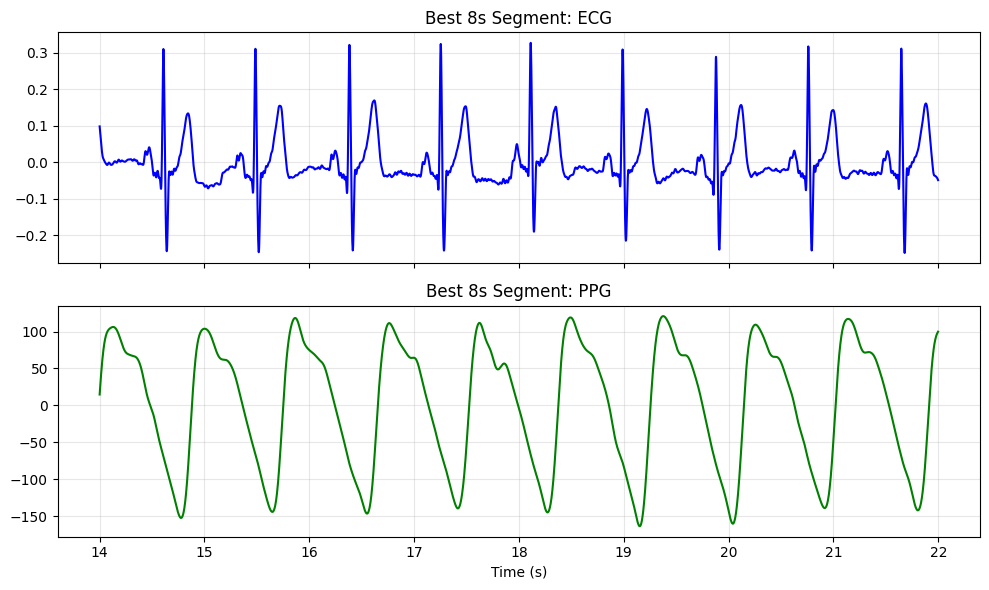

In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk
from scipy.stats import kurtosis
from scipy.io import savemat

# ==========================================
# 1. FILE CONFIGURATION
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)
#/kaggle/input/abp-dataset/measurements_auscultatory/measurements_auscultatory/a004/a004.initial.Static_challenge_start_1.tsv
#/kaggle/input/abp-dataset/measurements_oscillometric/measurements_oscillometric/o006/o006.initial.Supine_2.tsv
RELATIVE_FILE_PATH = os.path.join('measurements_auscultatory',
                                  'measurements_auscultatory',
                                  'a080',
                                  'a080.initial.Static_challenge_start_1.tsv')
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

def load_abp_data(file_path):
    if not os.path.exists(file_path): return None
    return pd.read_csv(file_path, sep='\t')

# ==========================================
# 2. PROCESSING (Includes Highpass Fix)
# ==========================================
def get_sampling_rate(df):
    if len(df) < 2: return 125.0
    return 1.0 / np.mean(np.diff(df['t']))

def process_all_signals(df):
    fs = get_sampling_rate(df)
    print(fs)
    df_filt = df.copy()
    
    # ECG Processing (With Highpass for Baseline Removal)
    if 'ekg' in df.columns:
        # 1. Highpass (0.5 Hz) - CRITICAL for baseline wander
        sos_hp = signal.butter(1, 0.5, btype='highpass', fs=fs, output='sos')
        sig_hp = signal.sosfiltfilt(sos_hp, df['ekg'].values)
        
        # 2. Notch (50-70 Hz)
        sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
        sig_notch = signal.sosfiltfilt(sos_notch, sig_hp)
        
        # 3. Lowpass (40 Hz)
        sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=40, btype='lowpass', fs=fs, output='sos')
        sig_lp = signal.sosfiltfilt(sos_lp, sig_notch)
        
        # 4. Invert Check
        corrected_ecg, _ = nk.ecg_invert(sig_lp, sampling_rate=int(fs))
        df_filt['ekg'] = corrected_ecg
        
    # PPG Processing
    if 'optical' in df.columns:
        sos_bp = signal.butter(4, [0.5, 10], btype='bandpass', fs=fs, output='sos')
        df_filt['optical'] = signal.sosfiltfilt(sos_bp, df['optical'].values)
        
    return df_filt, fs

# ==========================================
# 3. ADVANCED METRICS EXTRACTION
# ==========================================
def analyze_segment_metrics(ecg_chunk, ppg_chunk, fs):
    """
    Returns a dictionary with exact metrics for ranking.
    """
    metrics = {'score': 0, 'reasons': []}
    
    # --- 1. ECG SCORING ---
    try:
        q_class = nk.ecg_quality(ecg_chunk, sampling_rate=fs, method="zhao2018")
        if q_class == 'Excellent': metrics['score'] += 5
        elif q_class == 'Barely acceptable': metrics['score'] += 2
    except: pass

    # Kurtosis (Higher = Sharper peaks = Better)
    metrics['ecg_kurtosis'] = kurtosis(ecg_chunk)

    # Variance Check (Lower penalty threshold)
    ecg_std = np.std(ecg_chunk)
    if ecg_std > 0.25: 
        metrics['score'] -= 10
        metrics['reasons'].append("HighVar")
    else:
        metrics['score'] += 2

    # --- 2. PPG SCORING ---
    try:
        # Get raw correlation value (0.0 to 1.0)
        q_temp = np.mean(nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="templatematch"))
        metrics['ppg_match_val'] = q_temp
        
        if q_temp > 0.85: metrics['score'] += 5
        elif q_temp > 0.6: metrics['score'] += 3
    except:
        metrics['ppg_match_val'] = 0.0

    return metrics

# ==========================================
# 4. FIND THE BEST SEGMENT (RANKING LOGIC)
# ==========================================
def find_best_segment(df, fs, duration_sec=8):
    window_samples = int(duration_sec * fs)
    step_samples = int(1.0 * fs) # 1 second step
    
    candidates = []
    
    print("Scanning and ranking segments...")
    
    for i in range(0, len(df) - window_samples, step_samples):
        # Extract Data
        ecg_c = df['ekg'].iloc[i : i+window_samples].values
        ppg_c = df['optical'].iloc[i : i+window_samples].values
        
        # Analyze
        m = analyze_segment_metrics(ecg_c, ppg_c, fs)
        
        # Store Candidate
        candidate = {
            'start_idx': i,
            'end_idx': i+window_samples,
            'time_start': df['t'].iloc[i],
            'total_score': m['score'],
            'ppg_quality': m['ppg_match_val'], # Tie-breaker 1
            'ecg_sharpness': m['ecg_kurtosis'] # Tie-breaker 2
        }
        
        # Only keep decent candidates to save memory
        if m['score'] > 0:
            candidates.append(candidate)
            
    # --- SORTING LOGIC ---
    # 1. Sort by Total Score (Descending)
    # 2. Then by PPG Quality (Descending)
    # 3. Then by ECG Kurtosis (Descending)
    sorted_candidates = sorted(
        candidates, 
        key=lambda x: (x['total_score'], x['ppg_quality'], x['ecg_sharpness']), 
        reverse=True
    )
    
    if not sorted_candidates:
        print("No valid segments found.")
        return None
        
    best = sorted_candidates[0]
    print(f"\nWINNER FOUND!")
    print(f"Time: {best['time_start']:.1f}s")
    print(f"Score: {best['total_score']}")
    print(f"PPG Match: {best['ppg_quality']:.4f} (Perfect=1.0)")
    print(f"ECG Kurtosis: {best['ecg_sharpness']:.2f}")
    
    # Return the dataframe slice of the winner
    return df.iloc[best['start_idx'] : best['end_idx']].copy()

# MAIN RUN
# ==========================================
df = load_abp_data(FULL_FILE_PATH)
if df is not None:
    # 1. Process signals
    df_filt, fs = process_all_signals(df)
    
    # 2. Extract Best Segment (8s)
    best_segment = find_best_segment(df_filt, fs)
    
    if best_segment is not None:
        # --- SAVE AS .MAT FILE ---
        # Construct a dictionary of the data you want to save
        mat_data = {
            'ekg': best_segment['ekg'].values,
            'ppg': best_segment['optical'].values,
            'time': best_segment['t'].values,
            'fs': fs,
            'quality_score': 0  # Placeholder or actual score if you passed it through
        }
        
        # Save the file
        save_filename = "good_bad_ecg.mat"
        savemat(save_filename, mat_data)
        print(f"\nSUCCESS: Segment saved as '{save_filename}'")

        # 3. Plot The Winner
        t = best_segment['t']
        fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        
        ax[0].plot(t, best_segment['ekg'], 'b')
        ax[0].set_title("Best 8s Segment: ECG")
        ax[0].grid(True, alpha=0.3)
        
        ax[1].plot(t, best_segment['optical'], 'g')
        ax[1].set_title("Best 8s Segment: PPG")
        ax[1].set_xlabel("Time (s)")
        ax[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

Keys found in file: ['ekg', 'ppg', 'time', 'fs', 'quality_score']


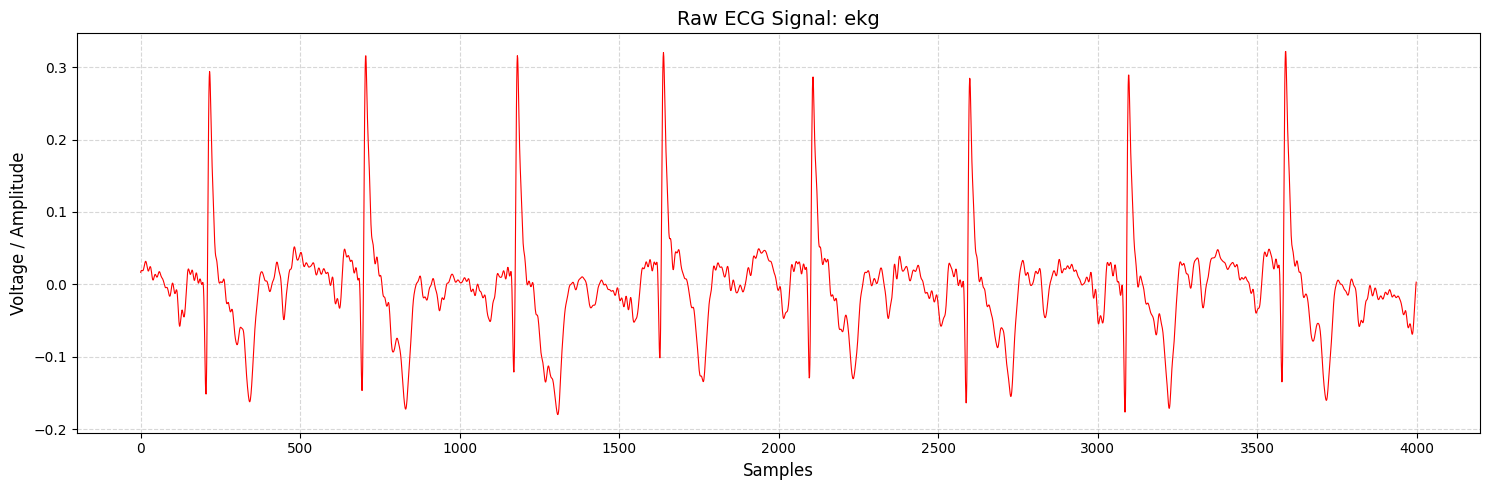

In [42]:
import scipy.io
import matplotlib.pyplot as plt
import os

# 1. Define the path
file_path = '/kaggle/working/bad_ecg.mat'

if os.path.exists(file_path):
    # 2. Load the .mat file
    mat_contents = scipy.io.loadmat(file_path)
    
    # 3. Find the data key (ignoring metadata like __header__)
    keys = [k for k in mat_contents.keys() if not k.startswith('__')]
    print(f"Keys found in file: {keys}")
    
    # Assuming the first key contains your ECG signal
    signal_key = keys[0]
    ecg_signal = mat_contents[signal_key].flatten()

    # 4. Plotting
    plt.figure(figsize=(15, 5))
    plt.plot(ecg_signal, color='red', linewidth=0.8)
    
    plt.title(f"Raw ECG Signal: {signal_key}", fontsize=14)
    plt.xlabel("Samples", fontsize=12)
    plt.ylabel("Voltage / Amplitude", fontsize=12)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Error: The file was not found at {file_path}. Please check the path.")

Available keys in file: ['ekg', 'ppg', 'time', 'fs', 'quality_score']


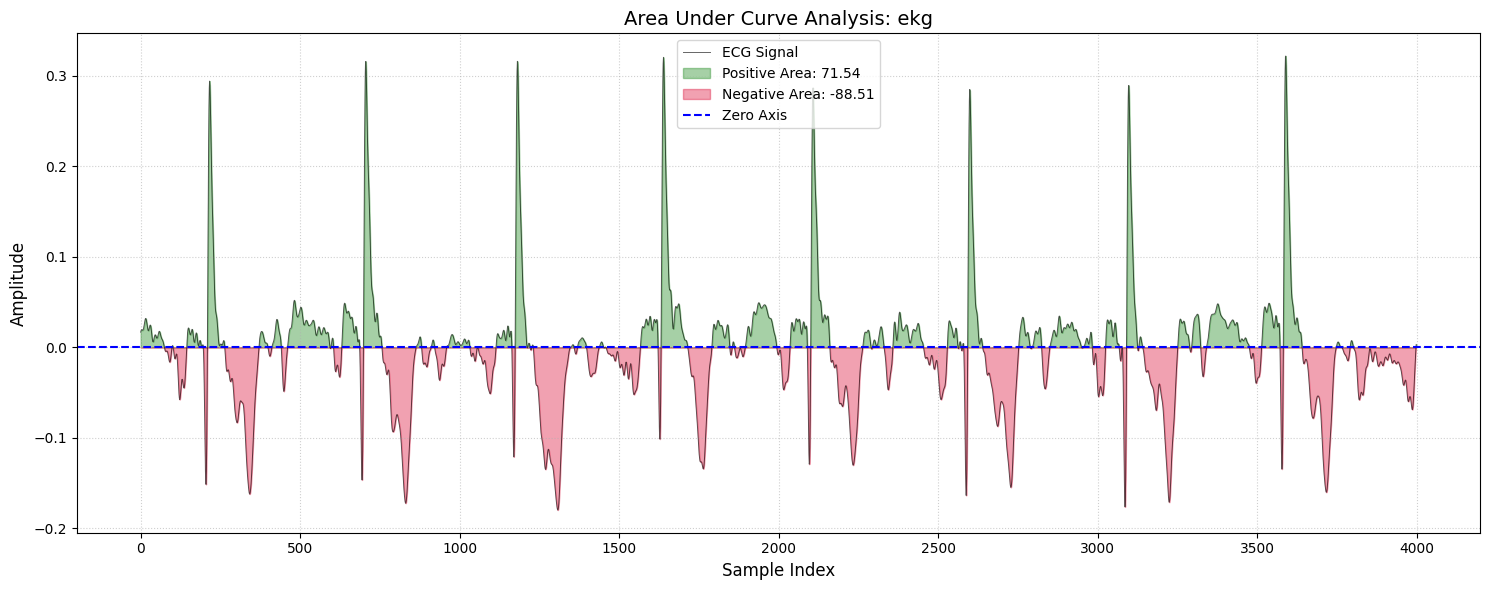


Analysis Results for ekg:
------------------------------------
Positive Area: 71.54
Negative Area: -88.51
Total Net Area: -16.98


In [44]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the .mat file
file_path = '/kaggle/working/bad_ecg.mat'

try:
    mat_data = scipy.io.loadmat(file_path)
    
    # Identify the correct signal key (ignoring metadata)
    keys = [k for k in mat_data.keys() if not k.startswith('__')]
    print(f"Available keys in file: {keys}")
    
    # Select the first key (usually the signal)
    signal_key = keys[0]
    signal = mat_data[signal_key].flatten()
    
    # 2. Separate into positive and negative components
    pos_signal = np.maximum(0, signal)
    neg_signal = np.minimum(0, signal)

    # 3. Calculate Areas using the updated function (no more warnings!)
    # Note: If np.trapezoid gives an error on very old NumPy versions, 
    # you can use from scipy.integrate import trapezoid
    pos_area = np.trapezoid(pos_signal)
    neg_area = np.trapezoid(neg_signal)

    # 4. Plotting and Visualization
    plt.figure(figsize=(15, 6))
    
    # Plot the full signal
    plt.plot(signal, color='black', linewidth=0.7, label='ECG Signal', alpha=0.6)
    
    # Color the areas
    plt.fill_between(range(len(signal)), pos_signal, 0, color='forestgreen', alpha=0.4, label=f'Positive Area: {pos_area:.2f}')
    plt.fill_between(range(len(signal)), neg_signal, 0, color='crimson', alpha=0.4, label=f'Negative Area: {neg_area:.2f}')
    
    # Zero Axis
    plt.axhline(0, color='blue', linestyle='--', linewidth=1.5, label='Zero Axis')
    
    plt.title(f"Area Under Curve Analysis: {signal_key}", fontsize=14)
    plt.xlabel("Sample Index", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

    # Print Results
    print(f"\nAnalysis Results for {signal_key}:")
    print(f"------------------------------------")
    print(f"Positive Area: {pos_area:,.2f}")
    print(f"Negative Area: {neg_area:,.2f}")
    print(f"Total Net Area: {(pos_area + neg_area):,.2f}")

except Exception as e:
    print(f"Error: {e}")


--- Best Segment Summary ---
Winner Start Time: 14.0s
Orientation: ⚠️ SIGNAL WAS FLIPPED (Originally Inverted)
Positive Area:   0.1968
Negative Area:   -0.1816
Quality Score:   9
----------------------------



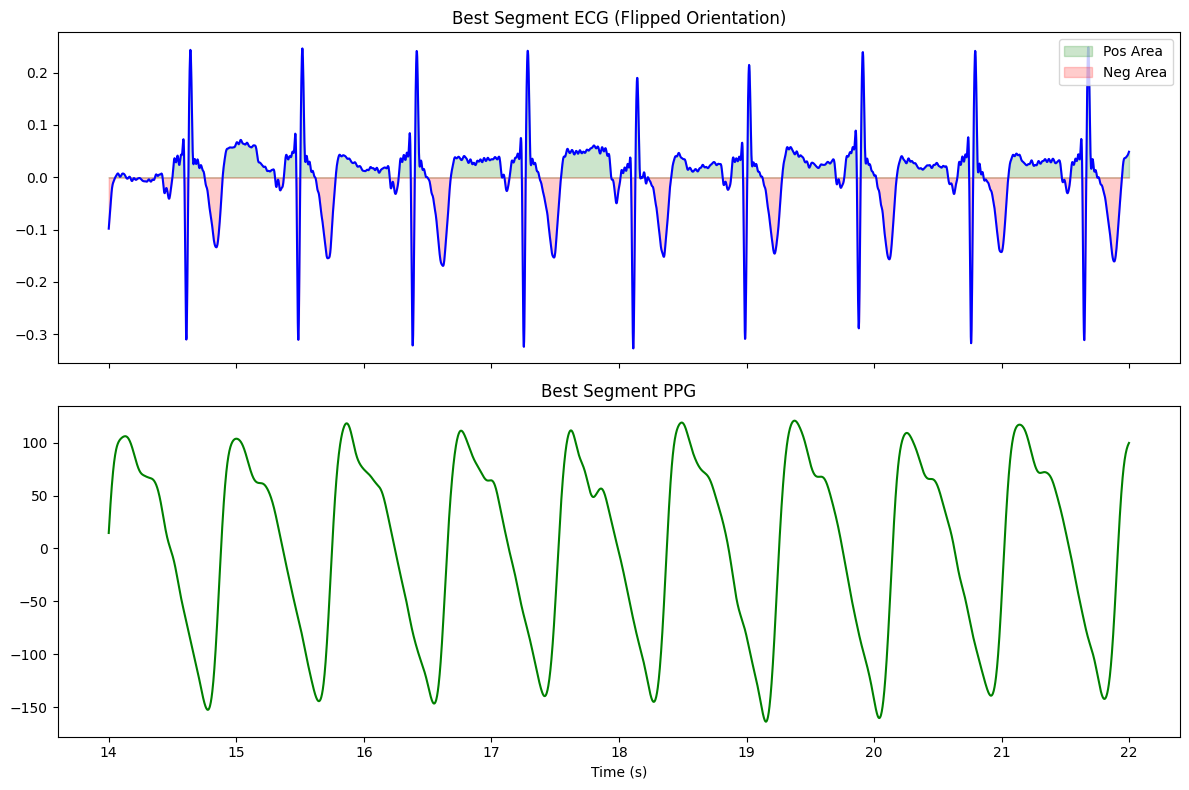

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk
from scipy.stats import kurtosis

# ==========================================
# 1. FILE CONFIGURATION
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)

# Path to your specific tsv file
RELATIVE_FILE_PATH = os.path.join('measurements_auscultatory',
                                  'measurements_auscultatory',
                                  'a080',
                                  'a080.initial.Static_challenge_start_1.tsv')
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

def load_abp_data(file_path):
    if not os.path.exists(file_path): return None
    return pd.read_csv(file_path, sep='\t')

# ==========================================
# 2. PROCESSING (Initial Filtering)
# ==========================================
def get_sampling_rate(df):
    if len(df) < 2: return 125.0
    return 1.0 / np.mean(np.diff(df['t']))

def process_all_signals(df):
    fs = get_sampling_rate(df)
    df_filt = df.copy()
    
    # ECG Filtering (Highpass, Notch, Lowpass)
    if 'ekg' in df.columns:
        sos_hp = signal.butter(1, 0.5, btype='highpass', fs=fs, output='sos')
        sig_hp = signal.sosfiltfilt(sos_hp, df['ekg'].values)
        
        sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
        sig_notch = signal.sosfiltfilt(sos_notch, sig_hp)
        
        sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=40, btype='lowpass', fs=fs, output='sos')
        df_filt['ekg'] = signal.sosfiltfilt(sos_lp, sig_notch)
        
    # PPG Processing
    if 'optical' in df.columns:
        sos_bp = signal.butter(4, [0.5, 10], btype='bandpass', fs=fs, output='sos')
        df_filt['optical'] = signal.sosfiltfilt(sos_bp, df['optical'].values)
        
    return df_filt, fs

# ==========================================
# 3. ADVANCED METRICS (Flip BEFORE Scoring)
# ==========================================
def analyze_segment_metrics(ecg_chunk, ppg_chunk, fs):
    metrics = {'score': 0, 'reasons': [], 'is_inverted': False}
    dx = 1.0 / fs
    
    # 1. Flip Logic check (Area comparison)
    pos_area = np.trapezoid(np.maximum(0, ecg_chunk), dx=dx)
    neg_area = np.trapezoid(np.minimum(0, ecg_chunk), dx=dx)
    
    working_ecg = ecg_chunk.copy()
    if abs(neg_area) > pos_area:
        working_ecg = working_ecg * -1 # Flip it
        metrics['is_inverted'] = True
    
    # 2. Quality scoring on the (now upright) signal
    try:
        q_class = nk.ecg_quality(working_ecg, sampling_rate=fs, method="zhao2018")
        if q_class == 'Excellent': metrics['score'] += 5
        elif q_class == 'Barely acceptable': metrics['score'] += 2
    except: pass

    metrics['ecg_kurtosis'] = kurtosis(working_ecg)
    
    # Variance check
    if np.std(working_ecg) > 0.25: 
        metrics['score'] -= 10
        metrics['reasons'].append("HighVar")
    else:
        metrics['score'] += 2

    # PPG match
    try:
        q_temp = np.mean(nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="templatematch"))
        metrics['ppg_match_val'] = q_temp
        if q_temp > 0.85: metrics['score'] += 5
    except: pass

    # Areas for final reporting
    metrics['pos_area'] = np.trapezoid(np.maximum(0, working_ecg), dx=dx)
    metrics['neg_area'] = np.trapezoid(np.minimum(0, working_ecg), dx=dx)

    return metrics, working_ecg

# ==========================================
# 4. FIND THE BEST SEGMENT (RANKING LOGIC)
# ==========================================
def find_best_segment(df, fs, duration_sec=8):
    window_samples = int(duration_sec * fs)
    step_samples = int(1.0 * fs) 
    candidates = []
    
    for i in range(0, len(df) - window_samples, step_samples):
        ecg_c = df['ekg'].iloc[i : i+window_samples].values
        ppg_c = df['optical'].iloc[i : i+window_samples].values
        
        m, corrected_ecg = analyze_segment_metrics(ecg_c, ppg_c, fs)
        
        candidates.append({
            'start_idx': i,
            'end_idx': i+window_samples,
            'time_start': df['t'].iloc[i],
            'total_score': m['score'],
            'ppg_quality': m.get('ppg_match_val', 0),
            'ecg_sharpness': m['ecg_kurtosis'],
            'corrected_ecg': corrected_ecg,
            'pos_area': m['pos_area'],
            'neg_area': m['neg_area'],
            'was_flipped': m['is_inverted']
        })
            
    sorted_candidates = sorted(candidates, key=lambda x: (x['total_score'], x['ppg_quality'], x['ecg_sharpness']), reverse=True)
    if not sorted_candidates: return None, None
        
    best = sorted_candidates[0]
    winner_df = df.iloc[best['start_idx'] : best['end_idx']].copy()
    winner_df['ekg'] = best['corrected_ecg']
    
    return winner_df, best

# ==========================================
# 5. MAIN EXECUTION
# ==========================================
df_raw = load_abp_data(FULL_FILE_PATH)

if df_raw is not None:
    # 1. Process signals (Filtering)
    df_filt, fs = process_all_signals(df_raw)
    
    # 2. Selection (Ranking + Flip Correction + Quality Check)
    best_segment, best_info = find_best_segment(df_filt, fs)
    
    if best_segment is not None:
        print(f"\n--- Best Segment Summary ---")
        print(f"Winner Start Time: {best_info['time_start']:.1f}s")
        
        # --- PRINT FLIP STATUS HERE ---
        if best_info['was_flipped']:
            print("Orientation: ⚠️ SIGNAL WAS FLIPPED (Originally Inverted)")
        else:
            print("Orientation: ✅ SIGNAL WAS NOT FLIPPED (Originally Upright)")
        
        print(f"Positive Area:   {best_info['pos_area']:.4f}")
        print(f"Negative Area:   {best_info['neg_area']:.4f}")
        print(f"Quality Score:   {best_info['total_score']}")
        print(f"----------------------------\n")

        # Final Plot
        t = best_segment['t']
        fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # ECG Plot with Area Fills
        ax[0].plot(t, best_segment['ekg'], 'b')
        ax[0].fill_between(t, np.maximum(0, best_segment['ekg']), 0, color='green', alpha=0.2, label="Pos Area")
        ax[0].fill_between(t, np.minimum(0, best_segment['ekg']), 0, color='red', alpha=0.2, label="Neg Area")
        
        status_text = "Flipped" if best_info['was_flipped'] else "Original"
        ax[0].set_title(f"Best Segment ECG ({status_text} Orientation)")
        ax[0].legend(loc='upper right')
        
        # PPG Plot
        ax[1].plot(t, best_segment['optical'], 'g')
        ax[1].set_title("Best Segment PPG")
        ax[1].set_xlabel("Time (s)")
        
        plt.tight_layout()
        plt.show()
else:
    print("File not found. Please check FULL_FILE_PATH.")

In [27]:
import os
import pandas as pd
import numpy as np
import scipy.signal as signal
import neurokit2 as nk
from scipy.stats import kurtosis

# ==========================================
# 1. CONFIGURATION
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input/abp-dataset'

DATA_SOURCES = [
    {
        "name": "Oscillometric",
        "dir": os.path.join(KAGGLE_INPUT_DIR, 'measurements_oscillometric', 'measurements_oscillometric'),
        "file_suffix": "initial.Supine_2.tsv"
    },
    {
        "name": "Auscultatory",
        "dir": os.path.join(KAGGLE_INPUT_DIR, 'measurements_auscultatory', 'measurements_auscultatory'),
        "file_suffix": "initial.Static_challenge_start_1.tsv"
    }
]

# ==========================================
# 2. PROCESSING LOGIC
# ==========================================
def get_sampling_rate(df):
    if len(df) < 2: return 125.0
    return 1.0 / np.mean(np.diff(df['t']))

def process_all_signals(df, fs):
    df_filt = df.copy()
    if 'ekg' in df.columns:
        sos_hp = signal.butter(1, 0.5, btype='highpass', fs=fs, output='sos')
        sig_hp = signal.sosfiltfilt(sos_hp, df['ekg'].values)
        sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
        sig_notch = signal.sosfiltfilt(sos_notch, sig_hp)
        sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=40, btype='lowpass', fs=fs, output='sos')
        sig_lp = signal.sosfiltfilt(sos_lp, sig_notch)
        corrected_ecg, _ = nk.ecg_invert(sig_lp, sampling_rate=int(fs))
        df_filt['ekg'] = corrected_ecg
    if 'optical' in df.columns:
        sos_bp = signal.butter(4, [0.5, 10], btype='bandpass', fs=fs, output='sos')
        df_filt['optical'] = signal.sosfiltfilt(sos_bp, df['optical'].values)
    return df_filt

# ==========================================
# 3. SCORING LOGIC
# ==========================================
def analyze_segment_metrics(ecg_chunk, ppg_chunk, fs):
    metrics = {'score': 0, 'ppg_match_val': 0.0, 'ecg_kurtosis': 0.0}
    try:
        q_class = nk.ecg_quality(ecg_chunk, sampling_rate=fs, method="zhao2018")
        if q_class == 'Excellent': metrics['score'] += 5
        elif q_class == 'Barely acceptable': metrics['score'] += 2
    except: pass

    # Calculate Kurtosis
    metrics['ecg_kurtosis'] = kurtosis(ecg_chunk)

    ecg_std = np.std(ecg_chunk)
    if ecg_std > 0.25: metrics['score'] -= 10
    else: metrics['score'] += 2

    try:
        q_temp = np.mean(nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="templatematch"))
        metrics['ppg_match_val'] = q_temp
        if q_temp > 0.85: metrics['score'] += 5
        elif q_temp > 0.6: metrics['score'] += 3
    except: pass

    return metrics

# ==========================================
# 4. BATCH EXECUTION
# ==========================================
ALL_RESULTS = []

for source in DATA_SOURCES:
    print(f"\n--- Processing: {source['name']} ---")
    if not os.path.exists(source['dir']): continue

    p_folders = sorted([f for f in os.listdir(source['dir']) if os.path.isdir(os.path.join(source['dir'], f))])

    for pid in p_folders:
        filename = f"{pid}.{source['file_suffix']}"
        file_path = os.path.join(source['dir'], pid, filename)
        if not os.path.exists(file_path): continue

        try:
            df = pd.read_csv(file_path, sep='\t')
            fs = get_sampling_rate(df)
            df_filt = process_all_signals(df, fs)

            win = int(8 * fs)
            step = int(1 * fs)
            candidates = []

            for i in range(0, len(df_filt) - win, step):
                m = analyze_segment_metrics(df_filt['ekg'].iloc[i:i+win].values, 
                                            df_filt['optical'].iloc[i:i+win].values, fs)
                candidates.append({
                    'score': m['score'],
                    'ppg_q': m['ppg_match_val'],
                    'ecg_k': m['ecg_kurtosis']
                })

            # Sort by Total Score, then PPG Quality, then Kurtosis
            candidates.sort(key=lambda x: (x['score'], x['ppg_q'], x['ecg_k']), reverse=True)
            
            best = candidates[0] if candidates else {'score': -99, 'ppg_q': 0, 'ecg_k': 0}
            status = "PASS" if best['score'] >= 10 else "LOW_QUALITY"

            ALL_RESULTS.append({
                'source': source['name'],
                'participant_id': pid,
                'max_score': best['score'],
                'ppg_quality': round(best['ppg_q'], 4),
                'ecg_kurtosis': round(best['ecg_k'], 4), # NEW COLUMN
                'status': status
            })
            print(f"[{source['name']}] {pid}: Score {best['score']} | Kurtosis {best['ecg_k']:.2f}")

        except Exception as e:
            print(f"Error {pid}: {e}")

# Save Summary
summary_df = pd.DataFrame(ALL_RESULTS)
summary_df.to_csv('quality_summary_with_kurtosis.csv', index=False)
print("\nSuccess! Results saved to 'quality_summary_with_kurtosis.csv'")


--- Processing: Oscillometric ---
[Oscillometric] o000: Score 12 | Kurtosis 19.17
[Oscillometric] o001: Score 9 | Kurtosis 3.47
[Oscillometric] o003: Score 12 | Kurtosis 16.46
[Oscillometric] o004: Score 9 | Kurtosis 7.15
[Oscillometric] o005: Score 12 | Kurtosis 9.48
[Oscillometric] o006: Score 12 | Kurtosis 24.07
[Oscillometric] o007: Score 12 | Kurtosis 21.12
[Oscillometric] o008: Score 12 | Kurtosis 11.66
[Oscillometric] o009: Score 12 | Kurtosis 23.16
[Oscillometric] o010: Score 12 | Kurtosis 25.39
[Oscillometric] o011: Score 12 | Kurtosis 28.41
[Oscillometric] o012: Score 12 | Kurtosis 15.13
[Oscillometric] o013: Score 12 | Kurtosis 12.14
[Oscillometric] o014: Score 12 | Kurtosis 11.77
[Oscillometric] o015: Score 12 | Kurtosis 10.38
[Oscillometric] o016: Score 12 | Kurtosis 33.11
[Oscillometric] o017: Score 12 | Kurtosis 21.86
[Oscillometric] o018: Score 9 | Kurtosis 8.51
[Oscillometric] o019: Score 12 | Kurtosis 5.59
[Oscillometric] o020: Score 12 | Kurtosis 8.36
[Oscillometric

/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Return

[Oscillometric] o340: Score 12 | Kurtosis 7.74
[Oscillometric] o341: Score 12 | Kurtosis 13.18
[Oscillometric] o342: Score 12 | Kurtosis 14.96
[Oscillometric] o343: Score 12 | Kurtosis 31.73
[Oscillometric] o344: Score 12 | Kurtosis 13.24
[Oscillometric] o345: Score 12 | Kurtosis 20.60
[Oscillometric] o346: Score 12 | Kurtosis 7.72
[Oscillometric] o347: Score 12 | Kurtosis 22.15
[Oscillometric] o348: Score 12 | Kurtosis 13.84
[Oscillometric] o349: Score 12 | Kurtosis 19.46
[Oscillometric] o351: Score 12 | Kurtosis 15.97
[Oscillometric] o352: Score 12 | Kurtosis 13.88
[Oscillometric] o353: Score -3 | Kurtosis 2.47
[Oscillometric] o354: Score 12 | Kurtosis 7.54
[Oscillometric] o355: Score 12 | Kurtosis 11.64
[Oscillometric] o356: Score 12 | Kurtosis 5.16
[Oscillometric] o357: Score 12 | Kurtosis 14.94
[Oscillometric] o358: Score 12 | Kurtosis 5.26
[Oscillometric] o359: Score 12 | Kurtosis 9.77
[Oscillometric] o360: Score 12 | Kurtosis 7.04
[Oscillometric] o361: Score 12 | Kurtosis 22.26


/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Return

[Auscultatory] a072: Score 12 | Kurtosis 21.70
[Auscultatory] a073: Score 12 | Kurtosis 17.57
[Auscultatory] a074: Score 12 | Kurtosis 21.68
[Auscultatory] a075: Score 12 | Kurtosis 5.50
[Auscultatory] a076: Score 12 | Kurtosis 20.80
[Auscultatory] a077: Score 12 | Kurtosis 24.59
[Auscultatory] a078: Score 12 | Kurtosis 11.66
[Auscultatory] a079: Score 12 | Kurtosis 7.88
[Auscultatory] a080: Score 9 | Kurtosis 4.60
[Auscultatory] a081: Score 12 | Kurtosis 11.44
[Auscultatory] a082: Score 12 | Kurtosis 17.05
[Auscultatory] a083: Score 12 | Kurtosis 21.49
[Auscultatory] a084: Score 7 | Kurtosis 3.71
[Auscultatory] a085: Score 12 | Kurtosis 15.29
[Auscultatory] a086: Score 12 | Kurtosis 29.21
[Auscultatory] a087: Score 12 | Kurtosis 18.89
[Auscultatory] a088: Score 12 | Kurtosis 30.99
[Auscultatory] a089: Score 12 | Kurtosis 12.77
[Auscultatory] a090: Score 12 | Kurtosis 19.12
[Auscultatory] a091: Score 9 | Kurtosis 4.61
[Auscultatory] a092: Score 9 | Kurtosis 3.66
[Auscultatory] a093: Sc

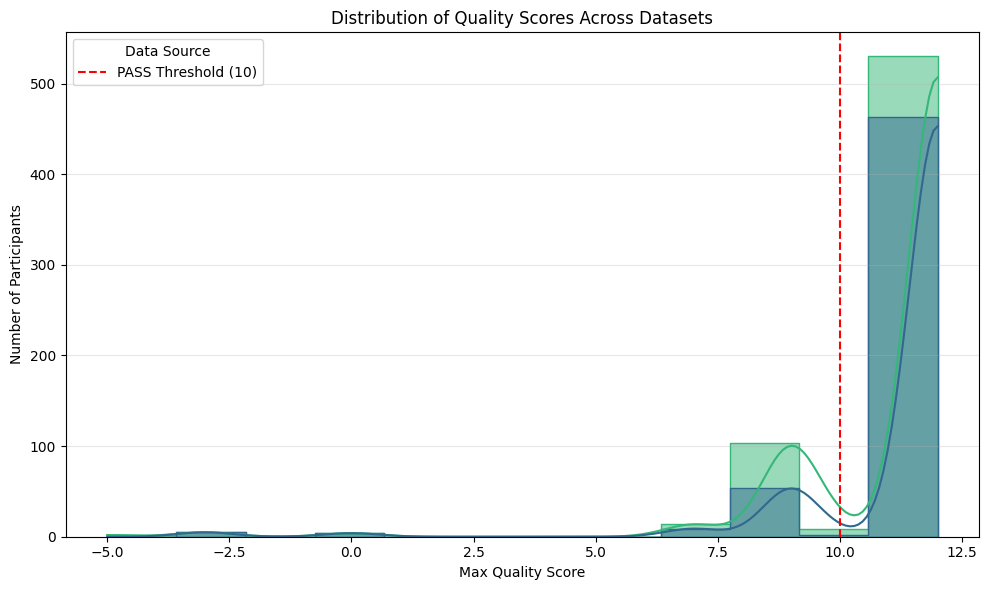

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the results CSV
df = pd.read_csv('quality_summary_with_kurtosis.csv')

# 2. Set up the plot
plt.figure(figsize=(10, 6))

# 3. Create a histogram with a density curve, grouped by source
sns.histplot(data=df, x='max_score', kde=True, hue='source', 
             element='step', palette='viridis', alpha=0.5)

# 4. Add the PASS threshold line
plt.axvline(10, color='red', linestyle='--', label='PASS Threshold (10)')

# 5. Labels and Styling
plt.title('Distribution of Quality Scores Across Datasets')
plt.xlabel('Max Quality Score')
plt.ylabel('Number of Participants')
plt.legend(title='Data Source')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('score_distribution_plot.png')

In [35]:
import pandas as pd

# 1. Load the summary report generated by the batch process
summary_file = 'quality_summary_with_kurtosis.csv'

try:
    df = pd.read_csv(summary_file)
    
    # 2. Filter for only Low Quality participants
    low_quality_df = df[df['status'] == 'LOW_QUALITY']
    
    print("="*50)
    print(f"LOW QUALITY PARTICIPANTS REPORT")
    print("="*50)
    
    # 3. Loop through sources to list IDs
    for source in df['source'].unique():
        source_low_q = low_quality_df[low_quality_df['source'] == source]
        total_in_source = len(df[df['source'] == source])
        low_q_count = len(source_low_q)
        
        failure_rate = (low_q_count / total_in_source) * 100 if total_in_source > 0 else 0
        
        print(f"\nSOURCE: {source}")
        print(f"Total Low Quality: {low_q_count} / {total_in_source} ({failure_rate:.1f}%)")
        
        if low_q_count > 0:
            # Join the IDs into a comma-separated string for easy reading
            id_list = ", ".join(source_low_q['participant_id'].tolist())
            print(f"IDs: {id_list}")
        else:
            print("IDs: None found.")

    # 4. Optional: Save the specific low-quality list to a new CSV for manual inspection
    low_quality_df.to_csv('low_quality_inspect_list.csv', index=False)
    print("\n" + "="*50)
    print("Specific list saved to 'low_quality_inspect_list.csv'")

except FileNotFoundError:
    print(f"Error: {summary_file} not found. Please run the batch processing script first.")

LOW QUALITY PARTICIPANTS REPORT

SOURCE: Oscillometric
Total Low Quality: 72 / 537 (13.4%)
IDs: o001, o004, o018, o039, o048, o049, o053, o055, o062, o070, o072, o085, o091, o098, o104, o107, o113, o120, o122, o126, o136, o140, o148, o159, o167, o171, o174, o180, o181, o222, o223, o230, o269, o270, o271, o278, o284, o298, o307, o312, o332, o353, o362, o375, o390, o392, o397, o400, o406, o414, o420, o428, o435, o438, o444, o449, o457, o459, o461, o466, o472, o492, o493, o495, o499, o500, o510, o515, o533, o534, o537, o538

SOURCE: Auscultatory
Total Low Quality: 128 / 666 (19.2%)
IDs: a000, a009, a011, a015, a018, a022, a040, a046, a061, a065, a067, a080, a084, a091, a092, a098, a114, a140, a143, a149, a156, a163, a165, a167, a168, a169, a170, a171, a182, a184, a189, a191, a193, a202, a209, a211, a220, a225, a234, a236, a240, a243, a244, a250, a262, a265, a273, a280, a288, a293, a298, a301, a302, a303, a305, a309, a312, a316, a318, a322, a324, a326, a333, a339, a342, a352, a353, a356, a

In [37]:
import pandas as pd

# Load the summary report
file_path = 'quality_summary_with_kurtosis.csv'

try:
    df = pd.read_csv(file_path)
    
    # 1. Filter for Low Quality (Score < 10)
    low_q = df[df['max_score'] < 10]
    
    # 2. Filter for Extremely Low Quality (Score < 0)
    extreme_noise = df[df['max_score'] < 0]

    print("="*60)
    print("DETAILED DATA QUALITY LIST")
    print("="*60)

    # Print the Extremely Low Quality List (Score < 0)
    print(f"\n[!] EXTREME NOISE DETECTED (Score < 0) - Count: {len(extreme_noise)}")
    if not extreme_noise.empty:
        for source in extreme_noise['source'].unique():
            ids = extreme_noise[extreme_noise['source'] == source]['participant_id'].tolist()
            print(f"  - {source}: {', '.join(ids)}")
    else:
        print("  - None found.")

    print("\n" + "-"*60)

    # Print the Low Quality List (Score < 10)
    print(f"[*] LOW QUALITY SIGNALS (Score < 10) - Count: {len(low_q)}")
    for source in low_q['source'].unique():
        ids = low_q[low_q['source'] == source]['participant_id'].tolist()
        # Showing first 10 IDs to keep the output clean
        display_ids = ids[:10]
        suffix = f"... (and {len(ids)-10} more)" if len(ids) > 10 else ""
        print(f"  - {source}: {', '.join(display_ids)}{suffix}")

    # 3. Save the lists to a text file for your records
    with open('failed_participants_log.txt', 'w') as f:
        f.write("EXTREME NOISE PARTICIPANTS (SCORE < 0):\n")
        f.write(", ".join(extreme_noise['participant_id'].tolist()) + "\n\n")
        f.write("LOW QUALITY PARTICIPANTS (SCORE < 10):\n")
        f.write(", ".join(low_q['participant_id'].tolist()))

    print("\n" + "="*60)
    print("Full list saved to 'failed_participants_log.txt'")

except FileNotFoundError:
    print(f"Error: {file_path} not found. Please ensure the CSV exists.")

DETAILED DATA QUALITY LIST

[!] EXTREME NOISE DETECTED (Score < 0) - Count: 12
  - Oscillometric: o332, o353, o362, o500, o534
  - Auscultatory: a061, a114, a143, a280, a357, a489, a525

------------------------------------------------------------
[*] LOW QUALITY SIGNALS (Score < 10) - Count: 200
  - Oscillometric: o001, o004, o018, o039, o048, o049, o053, o055, o062, o070... (and 62 more)
  - Auscultatory: a000, a009, a011, a015, a018, a022, a040, a046, a061, a065... (and 118 more)

Full list saved to 'failed_participants_log.txt'


# **Finding the best 8 second segment without downsampling the signal to 125Hz**

500.0
Scanning and ranking segments...

WINNER FOUND!
Time: 21.0s
Score: 12
PPG Match: 0.9994 (Perfect=1.0)
ECG Kurtosis: 24.07


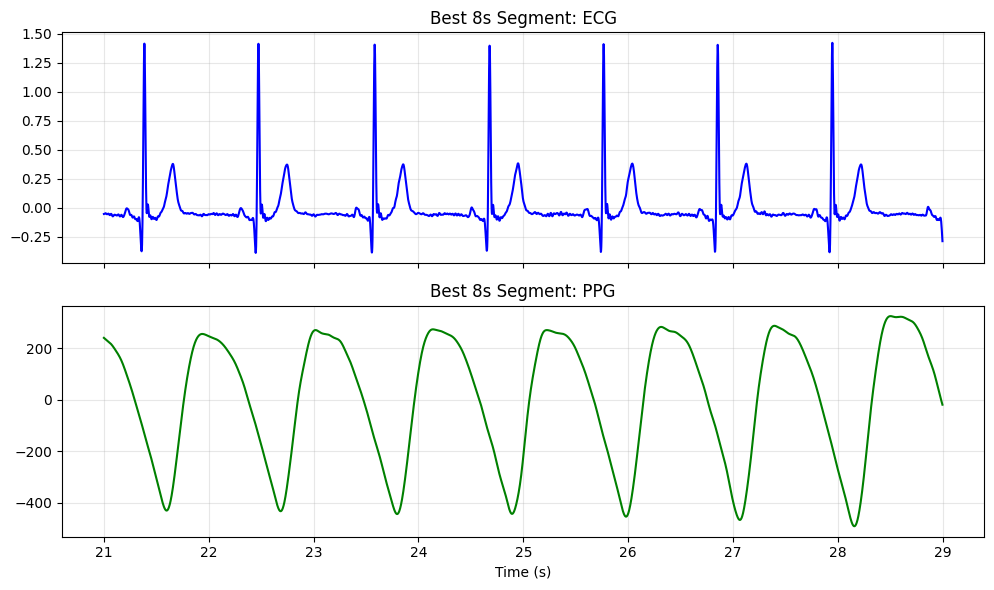

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk
from scipy.stats import kurtosis

# ==========================================
# 1. FILE CONFIGURATION
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)

#/kaggle/input/abp-dataset/measurements_oscillometric/measurements_oscillometric/o006/o006.initial.Supine_2.tsv
RELATIVE_FILE_PATH = os.path.join('measurements_oscillometric',
                                  'measurements_oscillometric',
                                  'o006',
                                  'o006.initial.Supine_2.tsv')
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

def load_abp_data(file_path):
    if not os.path.exists(file_path): return None
    return pd.read_csv(file_path, sep='\t')

# ==========================================
# 2. PROCESSING (Includes Highpass Fix)
# ==========================================
def get_sampling_rate(df):
    if len(df) < 2: return 125.0
    return 1.0 / np.mean(np.diff(df['t']))

def process_all_signals(df):
    fs = get_sampling_rate(df)
    print(fs)
    df_filt = df.copy()
    
    # ECG Processing (With Highpass for Baseline Removal)
    if 'ekg' in df.columns:
        # 1. Highpass (0.5 Hz) - CRITICAL for baseline wander
        sos_hp = signal.butter(1, 0.5, btype='highpass', fs=fs, output='sos')
        sig_hp = signal.sosfiltfilt(sos_hp, df['ekg'].values)
        
        # 2. Notch (50-70 Hz)
        sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
        sig_notch = signal.sosfiltfilt(sos_notch, sig_hp)
        
        # 3. Lowpass (40 Hz)
        sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=40, btype='lowpass', fs=fs, output='sos')
        sig_lp = signal.sosfiltfilt(sos_lp, sig_notch)
        
        # 4. Invert Check
        corrected_ecg, _ = nk.ecg_invert(sig_lp, sampling_rate=int(fs))
        df_filt['ekg'] = corrected_ecg
        
    # PPG Processing
    if 'optical' in df.columns:
        sos_bp = signal.butter(4, [0.5, 10], btype='bandpass', fs=fs, output='sos')
        df_filt['optical'] = signal.sosfiltfilt(sos_bp, df['optical'].values)
        
    return df_filt, fs

# ==========================================
# 3. ADVANCED METRICS EXTRACTION
# ==========================================
def analyze_segment_metrics(ecg_chunk, ppg_chunk, fs):
    """
    Returns a dictionary with exact metrics for ranking.
    """
    metrics = {'score': 0, 'reasons': []}
    
    # --- 1. ECG SCORING ---
    try:
        q_class = nk.ecg_quality(ecg_chunk, sampling_rate=fs, method="zhao2018")
        if q_class == 'Excellent': metrics['score'] += 5
        elif q_class == 'Barely acceptable': metrics['score'] += 2
    except: pass

    # Kurtosis (Higher = Sharper peaks = Better)
    metrics['ecg_kurtosis'] = kurtosis(ecg_chunk)

    # Variance Check (Lower penalty threshold)
    ecg_std = np.std(ecg_chunk)
    if ecg_std > 0.25: 
        metrics['score'] -= 10
        metrics['reasons'].append("HighVar")
    else:
        metrics['score'] += 2

    # --- 2. PPG SCORING ---
    try:
        # Get raw correlation value (0.0 to 1.0)
        q_temp = np.mean(nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="templatematch"))
        metrics['ppg_match_val'] = q_temp
        
        if q_temp > 0.85: metrics['score'] += 5
        elif q_temp > 0.6: metrics['score'] += 3
    except:
        metrics['ppg_match_val'] = 0.0

    return metrics

# ==========================================
# 4. FIND THE BEST SEGMENT (RANKING LOGIC)
# ==========================================
def find_best_segment(df, fs, duration_sec=8):
    window_samples = int(duration_sec * fs)
    step_samples = int(1.0 * fs) # 1 second step
    
    candidates = []
    
    print("Scanning and ranking segments...")
    
    for i in range(0, len(df) - window_samples, step_samples):
        # Extract Data
        ecg_c = df['ekg'].iloc[i : i+window_samples].values
        ppg_c = df['optical'].iloc[i : i+window_samples].values
        
        # Analyze
        m = analyze_segment_metrics(ecg_c, ppg_c, fs)
        
        # Store Candidate
        candidate = {
            'start_idx': i,
            'end_idx': i+window_samples,
            'time_start': df['t'].iloc[i],
            'total_score': m['score'],
            'ppg_quality': m['ppg_match_val'], # Tie-breaker 1
            'ecg_sharpness': m['ecg_kurtosis'] # Tie-breaker 2
        }
        
        # Only keep decent candidates to save memory
        if m['score'] > 0:
            candidates.append(candidate)
            
    # --- SORTING LOGIC ---
    # 1. Sort by Total Score (Descending)
    # 2. Then by PPG Quality (Descending)
    # 3. Then by ECG Kurtosis (Descending)
    sorted_candidates = sorted(
        candidates, 
        key=lambda x: (x['total_score'], x['ppg_quality'], x['ecg_sharpness']), 
        reverse=True
    )
    
    if not sorted_candidates:
        print("No valid segments found.")
        return None
        
    best = sorted_candidates[0]
    print(f"\nWINNER FOUND!")
    print(f"Time: {best['time_start']:.1f}s")
    print(f"Score: {best['total_score']}")
    print(f"PPG Match: {best['ppg_quality']:.4f} (Perfect=1.0)")
    print(f"ECG Kurtosis: {best['ecg_sharpness']:.2f}")
    
    # Return the dataframe slice of the winner
    return df.iloc[best['start_idx'] : best['end_idx']].copy()

# ==========================================
# MAIN RUN
# ==========================================
df = load_abp_data(FULL_FILE_PATH)
if df is not None:
    # 1. Process
    df_filt, fs = process_all_signals(df)
    
    # 2. Extract Best
    best_segment = find_best_segment(df_filt, fs)
    
    # 3. Plot The Winner
    if best_segment is not None:
        t = best_segment['t']
        fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        
        ax[0].plot(t, best_segment['ekg'], 'b')
        ax[0].set_title("Best 8s Segment: ECG")
        ax[0].grid(True, alpha=0.3)
        
        ax[1].plot(t, best_segment['optical'], 'g')
        ax[1].set_title("Best 8s Segment: PPG")
        ax[1].set_xlabel("Time (s)")
        ax[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# **Finding the best 8 second segment with downsampling the signal to 125Hz**

Original sampling rate: 500.0 Hz
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Data points: 15000 → 3750
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 3.0s
Score: 12
PPG Match: 0.9989 (Perfect=1.0)
ECG Kurtosis: 14.68


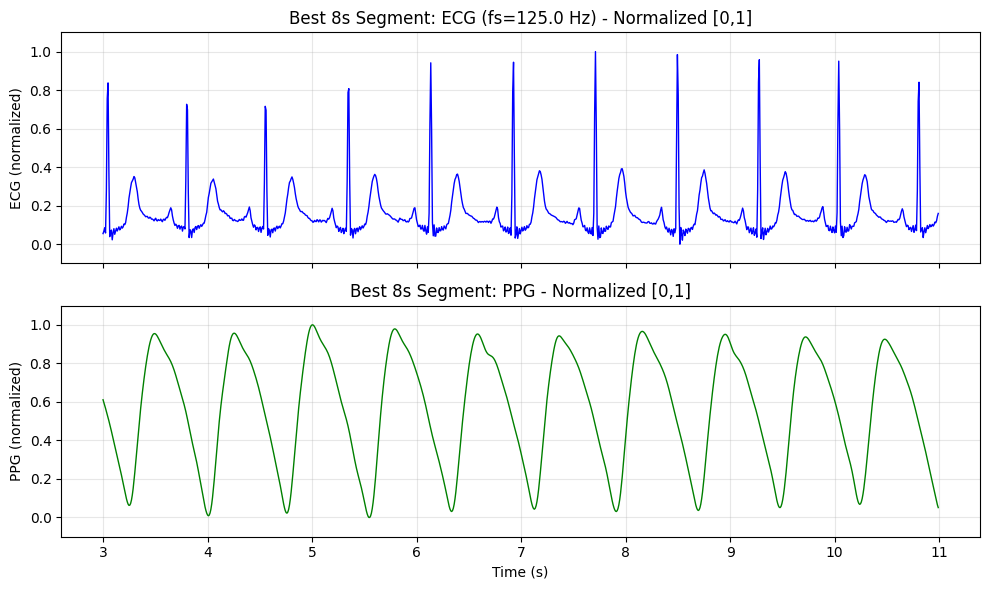

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk
from scipy.stats import kurtosis

# ==========================================
# 1. FILE CONFIGURATION
# ==========================================
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER)

RELATIVE_FILE_PATH = os.path.join('measurements_oscillometric',
                                  'measurements_oscillometric',
                                  'o003',
                                  'o003.initial.Supine_2.tsv')
FULL_FILE_PATH = os.path.join(DATA_DIR, RELATIVE_FILE_PATH)

# Target sampling rate for downsampling
TARGET_FS = 125  # Hz

def load_abp_data(file_path):
    if not os.path.exists(file_path): return None
    return pd.read_csv(file_path, sep='\t')

# ==========================================
# 2. DOWNSAMPLING FUNCTION
# ==========================================
def downsample_signal(signal_data, original_fs, target_fs):
    """
    Properly downsample a signal using anti-aliasing filter.
    
    Parameters:
    -----------
    signal_data : array-like
        Input signal to downsample
    original_fs : float
        Original sampling frequency
    target_fs : float
        Target sampling frequency
    
    Returns:
    --------
    downsampled_signal : ndarray
        Downsampled signal
    """
    if original_fs <= target_fs:
        # No downsampling needed
        return signal_data
    
    # Calculate decimation factor
    decimation_factor = int(np.round(original_fs / target_fs))
    
    # scipy.signal.decimate applies anti-aliasing filter automatically
    # It uses an 8th-order Chebyshev Type I lowpass filter by default
    downsampled = signal.decimate(signal_data, decimation_factor, ftype='iir', zero_phase=True)
    
    return downsampled

def downsample_dataframe(df, original_fs, target_fs):
    """
    Downsample entire dataframe including time vector.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with signal columns
    original_fs : float
        Original sampling frequency
    target_fs : float
        Target sampling frequency
    
    Returns:
    --------
    df_downsampled : pandas.DataFrame
        Downsampled dataframe
    actual_fs : float
        Actual achieved sampling rate
    """
    if original_fs <= target_fs:
        print(f"No downsampling needed. Original fs={original_fs:.1f} Hz")
        return df.copy(), original_fs
    
    decimation_factor = int(np.round(original_fs / target_fs))
    actual_fs = original_fs / decimation_factor
    
    print(f"Downsampling: {original_fs:.1f} Hz → {actual_fs:.1f} Hz (factor: {decimation_factor})")
    
    # Create new dataframe
    df_down = pd.DataFrame()
    
    # Downsample each signal column
    for col in df.columns:
        if col == 't':
            # Downsample time vector by simple indexing
            df_down['t'] = df['t'].iloc[::decimation_factor].values
        else:
            # Apply proper anti-aliasing downsampling
            df_down[col] = downsample_signal(df[col].values, original_fs, target_fs)
    
    # Reset index
    df_down.reset_index(drop=True, inplace=True)
    
    return df_down, actual_fs

# ==========================================
# 3. PROCESSING (Includes Highpass Fix)
# ==========================================
def get_sampling_rate(df):
    if len(df) < 2: return 125.0
    return 1.0 / np.mean(np.diff(df['t']))

def process_all_signals(df, fs):
    """
    Process signals with filters adapted to the sampling rate.
    """
    df_filt = df.copy()
    
    # ECG Processing (With Highpass for Baseline Removal)
    if 'ekg' in df.columns:
        # 1. Highpass (0.5 Hz) - CRITICAL for baseline wander
        sos_hp = signal.butter(1, 0.5, btype='highpass', fs=fs, output='sos')
        sig_hp = signal.sosfiltfilt(sos_hp, df['ekg'].values)
        
        # 2. Notch (50-70 Hz) - Only apply if fs > 140 Hz
        if fs > 140:
            sos_notch = signal.cheby1(N=3, rp=0.1, Wn=[50, 70], btype='bandstop', fs=fs, output='sos')
            sig_notch = signal.sosfiltfilt(sos_notch, sig_hp)
        else:
            sig_notch = sig_hp
            print("Skipping notch filter (fs too low)")
        
        # 3. Lowpass (40 Hz) - Ensure it's below Nyquist
        cutoff = min(40, fs/2 - 5)
        sos_lp = signal.ellip(N=7, rp=0.1, rs=60, Wn=cutoff, btype='lowpass', fs=fs, output='sos')
        sig_lp = signal.sosfiltfilt(sos_lp, sig_notch)
        
        # 4. Invert Check
        corrected_ecg, _ = nk.ecg_invert(sig_lp, sampling_rate=fs)
        df_filt['ekg'] = corrected_ecg
        
    # PPG Processing
    if 'optical' in df.columns:
        sos_bp = signal.butter(4, [0.5, 10], btype='bandpass', fs=fs, output='sos')
        df_filt['optical'] = signal.sosfiltfilt(sos_bp, df['optical'].values)
        
    return df_filt

# ==========================================
# 4. ADVANCED METRICS EXTRACTION
# ==========================================
def analyze_segment_metrics(ecg_chunk, ppg_chunk, fs):
    """
    Returns a dictionary with exact metrics for ranking.
    """
    metrics = {'score': 0, 'reasons': []}
    
    # --- 1. ECG SCORING ---
    try:
        q_class = nk.ecg_quality(ecg_chunk, sampling_rate=fs, method="zhao2018")
        if q_class == 'Excellent': metrics['score'] += 5
        elif q_class == 'Barely acceptable': metrics['score'] += 2
    except: pass

    # Kurtosis (Higher = Sharper peaks = Better)
    metrics['ecg_kurtosis'] = kurtosis(ecg_chunk)

    # Variance Check (Lower penalty threshold)
    ecg_std = np.std(ecg_chunk)
    if ecg_std > 0.25: 
        metrics['score'] -= 10
        metrics['reasons'].append("HighVar")
    else:
        metrics['score'] += 2

    # --- 2. PPG SCORING ---
    try:
        # Get raw correlation value (0.0 to 1.0)
        q_temp = np.mean(nk.ppg_quality(ppg_chunk, sampling_rate=fs, method="templatematch"))
        metrics['ppg_match_val'] = q_temp
        
        if q_temp > 0.85: metrics['score'] += 5
        elif q_temp > 0.6: metrics['score'] += 3
    except:
        metrics['ppg_match_val'] = 0.0

    return metrics

# ==========================================
# 5. FIND THE BEST SEGMENT (RANKING LOGIC)
# ==========================================
def find_best_segment(df, fs, duration_sec=8):
    window_samples = int(duration_sec * fs)
    step_samples = int(1.0 * fs) # 1 second step
    
    candidates = []
    
    print("Scanning and ranking segments...")
    
    for i in range(0, len(df) - window_samples, step_samples):
        # Extract Data
        ecg_c = df['ekg'].iloc[i : i+window_samples].values
        ppg_c = df['optical'].iloc[i : i+window_samples].values
        
        # Analyze
        m = analyze_segment_metrics(ecg_c, ppg_c, fs)
        
        # Store Candidate
        candidate = {
            'start_idx': i,
            'end_idx': i+window_samples,
            'time_start': df['t'].iloc[i],
            'total_score': m['score'],
            'ppg_quality': m['ppg_match_val'], # Tie-breaker 1
            'ecg_sharpness': m['ecg_kurtosis'] # Tie-breaker 2
        }
        
        # Only keep decent candidates to save memory
        if m['score'] > 0:
            candidates.append(candidate)
            
    # --- SORTING LOGIC ---
    sorted_candidates = sorted(
        candidates, 
        key=lambda x: (x['total_score'], x['ppg_quality'], x['ecg_sharpness']), 
        reverse=True
    )
    
    if not sorted_candidates:
        print("No valid segments found.")
        return None
        
    best = sorted_candidates[0]
    print(f"\nWINNER FOUND!")
    print(f"Time: {best['time_start']:.1f}s")
    print(f"Score: {best['total_score']}")
    print(f"PPG Match: {best['ppg_quality']:.4f} (Perfect=1.0)")
    print(f"ECG Kurtosis: {best['ecg_sharpness']:.2f}")
    
    return df.iloc[best['start_idx'] : best['end_idx']].copy()


# ==========================================
# 6. MIN-MAX NORMALIZATION (0 to 1)
# ==========================================
def normalize_signals(df):
    """
    Applies Min-Max normalization to ECG and PPG signals.
    Scales signals to range [0, 1].
    
    Formula: (x - min) / (max - min)
    """
    df_norm = df.copy()
    
    for col in ['ekg', 'optical']:
        if col in df_norm.columns:
            min_val = df_norm[col].min()
            max_val = df_norm[col].max()
            
            # Avoid division by zero if signal is flat/invalid
            if max_val > min_val:
                df_norm[col] = (df_norm[col] - min_val) / (max_val - min_val)
            else:
                print(f"Warning: {col} has no variation (min=max). Setting to 0.")
                df_norm[col] = 0.0
                
    return df_norm


# ==========================================
# MAIN RUN
# ==========================================
df = load_abp_data(FULL_FILE_PATH)
if df is not None:
    # 1. Get original sampling rate
    original_fs = get_sampling_rate(df)
    print(f"Original sampling rate: {original_fs:.1f} Hz")
    
    # 2. Downsample FIRST (before filtering)
    df_down, fs = downsample_dataframe(df, original_fs, TARGET_FS)
    print(f"Data points: {len(df)} → {len(df_down)}")
    
    # 3. Process with downsampled rate
    df_filt = process_all_signals(df_down, fs)
    
    # 4. Extract Best
    best_segment = find_best_segment(df_filt, fs)

    # 5. Normalize to [0, 1] range
    best_segment = normalize_signals(best_segment)
    
    # 6. Plot The Winner
    if best_segment is not None:
        t = best_segment['t']
        fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        
        ax[0].plot(t, best_segment['ekg'], 'b', linewidth=1)
        ax[0].set_title(f"Best 8s Segment: ECG (fs={fs:.1f} Hz) - Normalized [0,1]")
        ax[0].set_ylabel("ECG (normalized)")
        ax[0].set_ylim(-0.1, 1.1)  # Set y-axis limits for clarity
        ax[0].grid(True, alpha=0.3)
        
        ax[1].plot(t, best_segment['optical'], 'g', linewidth=1)
        ax[1].set_title("Best 8s Segment: PPG - Normalized [0,1]")
        ax[1].set_xlabel("Time (s)")
        ax[1].set_ylabel("PPG (normalized)")
        ax[1].set_ylim(-0.1, 1.1)  # Set y-axis limits for clarity
        ax[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [5]:
import os
import pandas as pd
import numpy as np

# --- 1. CONFIGURATION ---
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
# Path to the actual folder containing participant subfolders
OSCI_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER, 
                        'measurements_oscillometric', 'measurements_oscillometric')

TARGET_FS = 125.0
RESULTS_LIST = []

# --- 2. BATCH EXECUTION LOOP ---
# Get list of all participant folders (e.g., 'o001', 'o002'...)
participant_folders = [f for f in os.listdir(OSCI_DIR) if os.path.isdir(os.path.joisn(OSCI_DIR, f))]
participant_folders.sort()

print(f"Found {len(participant_folders)} participant folders. Starting validation...")

for pid in participant_folders:
    # Target file for each participant
    filename = f"{pid}.initial.Supine_2.tsv"
    file_path = os.path.join(OSCI_DIR, pid, filename)
    
    if not os.path.exists(file_path):
        print(f"Skipping {pid}: File {filename} not found.")
        continue

    try:
        # 1. Load Data
        df = load_abp_data(file_path)
        if df is None or len(df) == 0: continue
            
        # 2. Downsample
        original_fs = get_sampling_rate(df)
        df_down, fs = downsample_dataframe(df, original_fs, TARGET_FS)
        
        # 3. Filter
        df_filt = process_all_signals(df_down, fs)
        
        # 4. Rank Segments
        # We search for the best window using your existing ranking logic
        window_samples = int(8 * fs)
        step_samples = int(1.0 * fs)
        
        best_score_for_participant = -999
        found_any = False
        
        for i in range(0, len(df_filt) - window_samples, step_samples):
            ecg_c = df_filt['ekg'].iloc[i : i+window_samples].values
            ppg_c = df_filt['optical'].iloc[i : i+window_samples].values
            
            m = analyze_segment_metrics(ecg_c, ppg_c, fs)
            
            if m['score'] > best_score_for_participant:
                best_score_for_participant = m['score']
                found_any = True
        
        # 5. Store Result
        # A score > 10 usually indicates both ECG and PPG are high quality
        status = "PASS" if best_score_for_participant >= 10 else "LOW_QUALITY"
        if not found_any: status = "FAIL"
            
        RESULTS_LIST.append({
            'participant_id': pid,
            'max_quality_score': best_score_for_participant,
            'status': status
        })
        
        print(f"Processed {pid}: Best Score = {best_score_for_participant} ({status})")

    except Exception as e:
        print(f"Error processing {pid}: {e}")

# --- 3. SUMMARY REPORT ---
results_df = pd.DataFrame(RESULTS_LIST)
results_df.to_csv('quality_summary.csv', index=False)

print("\n--- FINAL SUMMARY ---")
print(results_df['status'].value_counts())

Found 548 participant folders. Starting validation...
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o000: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o001: Best Score = 9 (LOW_QUALITY)
Skipping o002: File o002.initial.Supine_2.tsv not found.
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o003: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o004: Best Score = 9 (LOW_QUALITY)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o005: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o006: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o007: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (fa

/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Return

Processed o340: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o341: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o342: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o343: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o344: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o345: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o346: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o347: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed o348: Best Score = 12 (PASS)
D

In [6]:
import os
import pandas as pd
import numpy as np

# --- 1. CONFIGURATION ---
KAGGLE_INPUT_DIR = '/kaggle/input'
DATASET_FOLDER = 'abp-dataset'
# Path to the actual folder containing participant subfolders
OSCI_DIR = os.path.join(KAGGLE_INPUT_DIR, DATASET_FOLDER, 
                        'measurements_auscultatory', 'measurements_auscultatory')

TARGET_FS = 125.0
RESULTS_LIST = []

# --- 2. BATCH EXECUTION LOOP ---
# Get list of all participant folders (e.g., 'o001', 'o002'...)
participant_folders = [f for f in os.listdir(OSCI_DIR) if os.path.isdir(os.path.join(OSCI_DIR, f))]
participant_folders.sort()

print(f"Found {len(participant_folders)} participant folders. Starting validation...")

for pid in participant_folders:
    # Target file for each participant
    filename = f"{pid}.initial.Static_challenge_start_1.tsv"
    file_path = os.path.join(OSCI_DIR, pid, filename)
    
    if not os.path.exists(file_path):
        print(f"Skipping {pid}: File {filename} not found.")
        continue

    try:
        # 1. Load Data
        df = load_abp_data(file_path)
        if df is None or len(df) == 0: continue
            
        # 2. Downsample
        original_fs = get_sampling_rate(df)
        df_down, fs = downsample_dataframe(df, original_fs, TARGET_FS)
        
        # 3. Filter
        df_filt = process_all_signals(df_down, fs)
        
        # 4. Rank Segments
        # We search for the best window using your existing ranking logic
        window_samples = int(8 * fs)
        step_samples = int(1.0 * fs)
        
        best_score_for_participant = -999
        found_any = False
        
        for i in range(0, len(df_filt) - window_samples, step_samples):
            ecg_c = df_filt['ekg'].iloc[i : i+window_samples].values
            ppg_c = df_filt['optical'].iloc[i : i+window_samples].values
            
            m = analyze_segment_metrics(ecg_c, ppg_c, fs)
            
            if m['score'] > best_score_for_participant:
                best_score_for_participant = m['score']
                found_any = True
        
        # 5. Store Result
        # A score > 10 usually indicates both ECG and PPG are high quality
        status = "PASS" if best_score_for_participant >= 10 else "LOW_QUALITY"
        if not found_any: status = "FAIL"
            
        RESULTS_LIST.append({
            'participant_id': pid,
            'max_quality_score': best_score_for_participant,
            'status': status
        })
        
        print(f"Processed {pid}: Best Score = {best_score_for_participant} ({status})")

    except Exception as e:
        print(f"Error processing {pid}: {e}")

# --- 3. SUMMARY REPORT ---
results_df = pd.DataFrame(RESULTS_LIST)
results_df.to_csv('quality_summary.csv', index=False)

print("\n--- FINAL SUMMARY ---")
print(results_df['status'].value_counts())

Found 672 participant folders. Starting validation...
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a000: Best Score = 9 (LOW_QUALITY)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a001: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a002: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a003: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a004: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a005: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a006: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a007: Bes

/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Return

Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a073: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a074: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a075: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a076: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a077: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a078: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a079: Best Score = 12 (PASS)
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Processed a080: Best Score = 9 (LOW_QUALITY)
Downsampling: 500.0 Hz → 125.0 Hz 

# **Participant id labeling whether low risk or high risk**

In [7]:
import os.path
import pandas as pd
import numpy as np

# --- FILE PATHS ---
KAGGLE_INPUT_DIR = '/kaggle/input/abp-dataset'
PARTICIPANTS_FILE = os.path.join(KAGGLE_INPUT_DIR, 'participants.tsv')
OUTPUT_FILE = 'participant_bp_classification.csv'

# Root paths for folder verification
AUSC_ROOT = os.path.join(KAGGLE_INPUT_DIR, 'measurements_auscultatory', 'measurements_auscultatory')
OSCI_ROOT = os.path.join(KAGGLE_INPUT_DIR, 'measurements_oscillometric', 'measurements_oscillometric')

def check_file_exists(pid_str):
    """Checks if the specific required measurement file exists for the PID."""
    if pid_str.startswith('a'):
        # Target: aXXX.initial.Static_challenge_start_1.tsv
        target = f"{pid_str}.initial.Static_challenge_start_1.tsv"
        path = os.path.join(AUSC_ROOT, pid_str, target)
    elif pid_str.startswith('o'):
        # Target: oXXX.initial.Supine_2.tsv
        target = f"{pid_str}.initial.Supine_2.tsv"
        path = os.path.join(OSCI_ROOT, pid_str, target)
    else:
        return False
    return os.path.exists(path)

def format_pid(pid):
    """Ensures PIDs are formatted correctly (e.g., 'a001' instead of '1')"""
    pid_str = str(pid).strip()
    if pid_str[0].isalpha():
        return pid_str
    # If it's just a number, default to 'a' prefix (Auscultatory)
    try:
        return f"a{int(float(pid_str)):03d}"
    except:
        return pid_str

try:
    # 1. Load the data
    df = pd.read_csv(PARTICIPANTS_FILE, delimiter='\t')
    print(f"Loaded {len(df)} participants from file.")

    # 2. Format PIDs and Check File Existence
    df['participant_id'] = df['pid'].apply(format_pid)
    print("Verifying measurement files existence...")
    df['file_exists'] = df['participant_id'].apply(check_file_exists)
    
    # 3. Filter only those with existing files
    df_filtered = df[df['file_exists'] == True].copy()
    removed_count = len(df) - len(df_filtered)

    # 4. Apply Hypertension Labeling Logic
    # Using np.select for clean binary labeling
    conditions = [
        (df_filtered['high_blood_pressure'] == 1),(df_filtered['high_blood_pressure'] == 0)
    ]
    choices = ['Hypertensive', 'Non-Hypertensive']
    
    df_filtered['bp_status'] = np.select(conditions, choices, default='Unknown')

    # 5. Prepare Final Output
    output_df = df_filtered[['participant_id', 'bp_status']]
    output_df.columns = ['Participant_ID', 'BP_Classification']

    # 6. Save to CSV
    output_df.to_csv(OUTPUT_FILE, index=False)

    # --- PRINT SUMMARY ---
    print("\n" + "="*40)
    print("PROCESSING COMPLETE")
    print("="*40)
    print(f"Participants removed (missing files): {removed_count}")
    print(f"Participants saved to CSV:          {len(output_df)}")
    print("\nBreakdown of saved participants:")
    print(output_df['BP_Classification'].value_counts())
    print("\nFirst 5 rows:")
    print(output_df.head())

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Loaded 1221 participants from file.
Verifying measurement files existence...

PROCESSING COMPLETE
Participants removed (missing files): 18
Participants saved to CSV:          1203

Breakdown of saved participants:
BP_Classification
Non-Hypertensive    775
Hypertensive        428
Name: count, dtype: int64

First 5 rows:
  Participant_ID BP_Classification
0           o000  Non-Hypertensive
1           o001  Non-Hypertensive
3           o003  Non-Hypertensive
4           o004  Non-Hypertensive
5           o005  Non-Hypertensive


# **Train test data splitting**

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load the file
# Note: Ensure you aren't accidentally reading the header as a data row
df = pd.read_csv('participant_bp_classification.csv') 

# 2. Identify and remove classes with only 1 member
counts = df['BP_Classification'].value_counts()
valid_classes = counts[counts >= 2].index
df_filtered = df[df['BP_Classification'].isin(valid_classes)].copy()

print(f"Original rows: {len(df)}")
print(f"Rows after removing rare classes: {len(df_filtered)}")
print("Class distribution:\n", df_filtered['BP_Classification'].value_counts())

# 3. Split the filtered data
train_df, test_df = train_test_split(
    df_filtered, 
    test_size=0.2, 
    stratify=df_filtered['BP_Classification'], 
    random_state=42
)

# 4. Save as new files
train_df.to_csv('train_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)

print("\nFiles successfully created: train_split.csv and test_split.csv")

Original rows: 1203
Rows after removing rare classes: 1203
Class distribution:
 BP_Classification
Non-Hypertensive    775
Hypertensive        428
Name: count, dtype: int64

Files successfully created: train_split.csv and test_split.csv


In [11]:
import os
import pandas as pd
import numpy as np

# --- 1. CONFIGURATION ---
KAGGLE_INPUT_DIR = '/kaggle/input/abp-dataset'
AUSC_ROOT = os.path.join(KAGGLE_INPUT_DIR, 'measurements_auscultatory', 'measurements_auscultatory')
OSCI_ROOT = os.path.join(KAGGLE_INPUT_DIR, 'measurements_oscillometric', 'measurements_oscillometric')
LABEL_FILE = 'participant_bp_classification.csv'
TARGET_FS = 125.0

processed_data_dict = {}
failure_reasons = []  # List to track the 20 missing participants

labels_df = pd.read_csv(LABEL_FILE, header=None, names=['Participant_ID', 'BP_Classification'])
print(f"Starting batch processing for {len(labels_df)} participants...")

# --- 2. PROCESSING LOOP ---
for _, row in labels_df.iterrows():
    pid = row['Participant_ID']
    file_path = None
    
    # Path logic
    if pid.startswith('a'):
        target = f"{pid}.initial.Static_challenge_start_1.tsv"
        file_path = os.path.join(AUSC_ROOT, pid, target)
    elif pid.startswith('o'):
        target = f"{pid}.initial.Supine_2.tsv"
        file_path = os.path.join(OSCI_ROOT, pid, target)
    
    # Check 1: File Existence
    if not file_path or not os.path.exists(file_path):
        failure_reasons.append({'Participant_ID': pid, 'reason': 'File Not Found'})
        continue
        
    try:
        # 1. Load and Downsample
        df_raw = load_abp_data(file_path)
        original_fs = get_sampling_rate(df_raw)
        df_down, fs = downsample_dataframe(df_raw, original_fs, TARGET_FS) 
        
        # 2. Filter
        df_filt = process_all_signals(df_down, fs)
        
        # 3. Quality Search
        best_segment = find_best_segment(df_filt, fs)
        
        if best_segment is not None:
            # Normalize and Save - FIXED FUNCTION NAME
            best_segment_norm = normalize_signals(best_segment)  # <-- CHANGED FROM normalize_dataframe
            combined_matrix = np.vstack((best_segment_norm['ekg'].values, 
                                         best_segment_norm['optical'].values)).T
            processed_data_dict[pid] = combined_matrix
        else:
            # Check 2: Quality Rejection
            failure_reasons.append({'Participant_ID': pid, 'reason': 'Low Quality (Score <= 0)'})
            
    except Exception as e:
        # Check 3: Technical Error
        failure_reasons.append({'Participant_ID': pid, 'reason': f'Processing Error: {str(e)}'})

# --- 3. SAVING & REPORTING ---
np.savez_compressed('all_participant_matrices.npz', **processed_data_dict)

# Save the failure log to see the missing 20
fail_df = pd.DataFrame(failure_reasons)
fail_df.to_csv('rejected_participants.csv', index=False)

print(f"\nFinished!")
print(f"Successfully processed: {len(processed_data_dict)}")
print(f"Rejected/Missing: {len(fail_df)}")
print("\nBreakdown of failures:")
print(fail_df['reason'].value_counts())

Starting batch processing for 1204 participants...
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 7.0s
Score: 12
PPG Match: 0.9976 (Perfect=1.0)
ECG Kurtosis: 19.12
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 11.0s
Score: 9
PPG Match: 0.9982 (Perfect=1.0)
ECG Kurtosis: 4.08
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 3.0s
Score: 12
PPG Match: 0.9989 (Perfect=1.0)
ECG Kurtosis: 14.68
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 0.0s
Score: 9
PPG Match: 0.9746 (Perfect=1.0)
ECG Kurtosis: 6.20
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 10.0s
Sco

/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Return


WINNER FOUND!
Time: 5.0s
Score: 12
PPG Match: 0.8668 (Perfect=1.0)
ECG Kurtosis: 7.66
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 5.0s
Score: 12
PPG Match: 0.9960 (Perfect=1.0)
ECG Kurtosis: 12.43
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 11.0s
Score: 12
PPG Match: 0.9988 (Perfect=1.0)
ECG Kurtosis: 14.88
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 12.0s
Score: 12
PPG Match: 0.9941 (Perfect=1.0)
ECG Kurtosis: 31.47
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 19.0s
Score: 12
PPG Match: 0.9958 (Perfect=1.0)
ECG Kurtosis: 13.30
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking 

/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Return


WINNER FOUND!
Time: 11.0s
Score: 12
PPG Match: 0.9916 (Perfect=1.0)
ECG Kurtosis: 17.66
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 4.0s
Score: 12
PPG Match: 0.9979 (Perfect=1.0)
ECG Kurtosis: 20.62
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 2.0s
Score: 12
PPG Match: 0.9953 (Perfect=1.0)
ECG Kurtosis: 5.52
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 3.0s
Score: 12
PPG Match: 0.9844 (Perfect=1.0)
ECG Kurtosis: 20.88
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking segments...

WINNER FOUND!
Time: 2.0s
Score: 12
PPG Match: 0.9105 (Perfect=1.0)
ECG Kurtosis: 24.42
Downsampling: 500.0 Hz → 125.0 Hz (factor: 4)
Skipping notch filter (fs too low)
Scanning and ranking se

In [12]:
# Assuming you have already run the batch processing loop above
if len(failure_reasons) > 0:
    # Convert the failure list to a DataFrame for easy viewing
    fail_df = pd.DataFrame(failure_reasons)
    
    # Extract only the participant IDs into a list
    rejected_ids = fail_df['Participant_ID'].tolist()
    
    print(f"--- List of {len(rejected_ids)} Rejected/Missing Participant IDs ---")
    print(rejected_ids)
    
    # Optional: Print with their specific reasons for rejection
    print("\n--- Detailed Breakdown ---")
    for index, row in fail_df.iterrows():
        print(f"ID: {row['Participant_ID']} | Reason: {row['reason']}")
else:
    print("No participants were rejected. All 1203 were processed successfully!")

--- List of 21 Rejected/Missing Participant IDs ---
['Participant_ID', 'o332', 'o353', 'o362', 'o435', 'o449', 'o459', 'o472', 'o500', 'o534', 'a061', 'a114', 'a143', 'a280', 'a303', 'a357', 'a462', 'a488', 'a489', 'a525', 'a542']

--- Detailed Breakdown ---
ID: Participant_ID | Reason: File Not Found
ID: o332 | Reason: Low Quality (Score <= 0)
ID: o353 | Reason: Low Quality (Score <= 0)
ID: o362 | Reason: Low Quality (Score <= 0)
ID: o435 | Reason: Low Quality (Score <= 0)
ID: o449 | Reason: Low Quality (Score <= 0)
ID: o459 | Reason: Low Quality (Score <= 0)
ID: o472 | Reason: Low Quality (Score <= 0)
ID: o500 | Reason: Low Quality (Score <= 0)
ID: o534 | Reason: Low Quality (Score <= 0)
ID: a061 | Reason: Low Quality (Score <= 0)
ID: a114 | Reason: Low Quality (Score <= 0)
ID: a143 | Reason: Low Quality (Score <= 0)
ID: a280 | Reason: Low Quality (Score <= 0)
ID: a303 | Reason: Low Quality (Score <= 0)
ID: a357 | Reason: Low Quality (Score <= 0)
ID: a462 | Reason: Low Quality (Score

In [13]:
import numpy as np
import pandas as pd
import os

# 1. Load the data
npz_path = '/kaggle/working/all_participant_matrices.npz'
csv_path = '/kaggle/working/all_participants_ground_truth.csv'

# Check if files exist to avoid errors
if not os.path.exists(npz_path):
    print(f"Error: {npz_path} not found.")
else:
    data = np.load(npz_path)
    
    # 2. Initialize tracking
    valid_participants = []
    invalid_participants = []
    
    # 3. Iterate through all arrays in the NPZ file
    for key in data.files:
        matrix = data[key]
        
        # Check if the matrix has 2 columns (ECG and PPG)
        # Assuming shape is (Length, Channels) -> (1000, 2)
        if len(matrix.shape) == 2 and matrix.shape[1] == 2:
            valid_participants.append(key)
        else:
            invalid_participants.append({
                'Participant_ID': key,
                'reason': f"Unexpected shape {matrix.shape}. Expected 2 channels."
            })

    # 4. Final Reporting Logic (Updated based on your snippet)
    total_found = len(data.files)
    success_count = len(valid_participants)
    fail_count = len(invalid_participants)

    print("==================================================")
    print(f"TOTAL ARRAYS IN NPZ: {total_found}")
    print(f"PARTICIPANTS WITH BOTH ECG & PPG: {success_count}")
    print(f"PARTICIPANTS REJECTED: {fail_count}")
    print("==================================================")

    if fail_count > 0:
        fail_df = pd.DataFrame(invalid_participants)
        rejected_ids = fail_df['Participant_ID'].tolist()
        
        print(f"\n--- List of {fail_count} Rejected Participant IDs ---")
        print(rejected_ids)
        
        print("\n--- Detailed Breakdown of Rejections ---")
        for index, row in fail_df.iterrows():
            print(f"ID: {row['Participant_ID']} | Reason: {row['reason']}")
    else:
        print("\nSuccess! Every array in the file contains both ECG and PPG segments.")

    # 5. Cross-reference with Ground Truth CSV (if you want to see who is missing)
    if os.path.exists(csv_path):
        df_labels = pd.read_csv(csv_path)
        # Using the first column or 'id' as the participant identifier
        id_col = 'id' if 'id' in df_labels.columns else df_labels.columns[0]
        csv_ids = set(df_labels[id_col].astype(str).tolist())
        npz_ids = set(valid_participants)
        
        missing_from_npz = csv_ids - npz_ids
        if missing_from_npz:
            print(f"\nNOTE: {len(missing_from_npz)} participants in CSV have NO matching segment in NPZ.")
            # print(list(missing_from_npz))

TOTAL ARRAYS IN NPZ: 1183
PARTICIPANTS WITH BOTH ECG & PPG: 1183
PARTICIPANTS REJECTED: 0

Success! Every array in the file contains both ECG and PPG segments.


In [43]:
import numpy as np
import pandas as pd
import os

# Define paths
npz_path = '/kaggle/working/all_participant_matrices.npz'
csv_path = '/kaggle/working/all_participants_ground_truth.csv'

if os.path.exists(npz_path) and os.path.exists(csv_path):
    # 1. Load the NPZ keys (IDs)
    signals = np.load(npz_path)
    npz_ids = set(signals.files)
    
    # 2. Load the CSV IDs
    df_labels = pd.read_csv(csv_path)
    # Detect the ID column (checks for 'id' or uses the first column)
    id_col = 'id' if 'id' in df_labels.columns else df_labels.columns[0]
    csv_ids = set(df_labels[id_col].astype(str).tolist())
    
    # 3. Calculate intersections and differences
    both_include = csv_ids.intersection(npz_ids)
    only_in_csv = csv_ids - npz_ids
    only_in_npz = npz_ids - csv_ids
    
    # 4. Print results
    print("==================================================")
    print(f"Total IDs in CSV:          {len(csv_ids)}")
    print(f"Total IDs in NPZ:          {len(npz_ids)}")
    print("--------------------------------------------------")
    print(f"IDs IN BOTH (Ready):       {len(both_include)}")
    print(f"IDs ONLY in CSV (Missing): {len(only_in_csv)}")
    print(f"IDs ONLY in NPZ (No Label):{len(only_in_npz)}")
    print("==================================================")
    
    # Optional: see the IDs that are missing from either side
    if len(only_in_csv) > 0:
        print(f"\nExample missing from NPZ: {list(only_in_csv)[:5]}")
        
else:
    print("Error: Ensure both files exist at the specified paths.")

Total IDs in CSV:          1123
Total IDs in NPZ:          1183
--------------------------------------------------
IDs IN BOTH (Ready):       1098
IDs ONLY in CSV (Missing): 25
IDs ONLY in NPZ (No Label):85

Example missing from NPZ: ['a413', 'o500', 'a488', 'a280', 'o534']


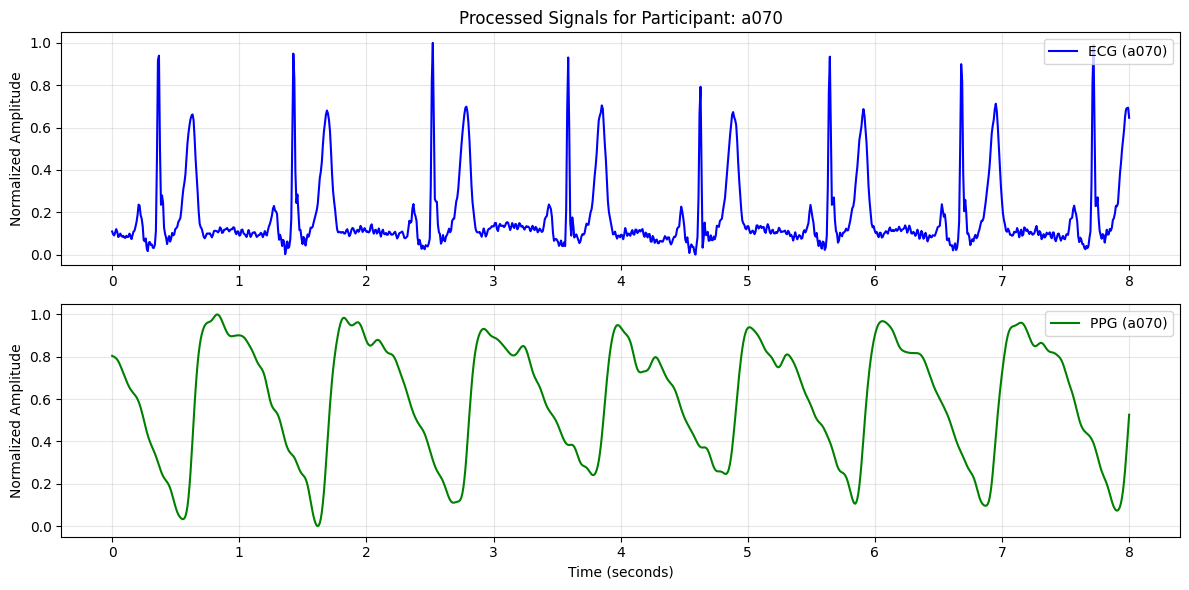

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the processed data
data = np.load('all_participant_matrices.npz')

# 2. Select a Participant ID
# Replace 'a001' with the specific PID you want to view
pid_to_plot = 'a070' 

if pid_to_plot in data:
    # Extract the (1000, 2) matrix
    signal_matrix = data[pid_to_plot]
    
    # Split into individual signals
    ecg_signal = signal_matrix[:, 0]
    ppg_signal = signal_matrix[:, 1]
    
    # Create a time axis (1000 points at 125Hz = 8 seconds)
    time = np.linspace(0, 8, 1000)

    # 3. Plotting
    plt.figure(figsize=(12, 6))

    # Plot ECG
    plt.subplot(2, 1, 1)
    plt.plot(time, ecg_signal, color='blue', label=f'ECG ({pid_to_plot})')
    plt.title(f"Processed Signals for Participant: {pid_to_plot}")
    plt.ylabel("Normalized Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    # Plot PPG
    plt.subplot(2, 1, 2)
    plt.plot(time, ppg_signal, color='green', label=f'PPG ({pid_to_plot})')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Normalized Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print(f"ID {pid_to_plot} not found. Available IDs: {list(data.keys())[:5]}...")

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ==========================================
# 1. ReSE: Residual Self-Encoding Module
# [cite: 173] Section II.A
# ==========================================
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # "Each Ri incorporates two convolutional layers C1 and C2" [cite: 176]
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Shortcut connection Si [cite: 180]
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # [cite: 178] Ri(X) = Ni(...) + Si(X)
        out = self.relu(out)
        return out

class ReSE(nn.Module):
    def __init__(self):
        super(ReSE, self).__init__()
        # "Each block consists of three sequential residual blocks R1, R2, and R3" [cite: 175]
        # Progressively increase channels from 1 to 128
        self.block1 = ResidualBlock(1, 32, stride=2)
        self.block2 = ResidualBlock(32, 64, stride=2)
        self.block3 = ResidualBlock(64, 128, stride=2) # Final output channels = 128 [cite: 187]

    def forward(self, x):
        # Input shape: (Batch, 1, Length)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x

# ==========================================
# 2. CCFE: Cascading Cross-Feature Enhancer
# [cite: 188] Section II.B
# ==========================================
class CCFE(nn.Module):
    def __init__(self, in_channels=256): # 128 (ECG) + 128 (PPG) = 256
        super(CCFE, self).__init__()
        
        # Adaptive cSE Submodule [cite: 194]
        # C1: Channel mixing (Conv1d)
        self.c1 = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        # C2: Depth-wise convolution
        self.c2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        # C3: Point-wise convolution
        self.c3 = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.bn = nn.BatchNorm1d(in_channels)

        # Squeeze-and-Excitation Mechanism [cite: 196]
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // 16) # Reduction ratio 16 [cite: 198]
        self.fc2 = nn.Linear(in_channels // 16, in_channels)
        self.sigmoid = nn.Sigmoid()

        # Cross-Modal Layer (2 Residual Blocks) [cite: 205]
        self.res_block1 = ResidualBlock(in_channels, in_channels)
        self.res_block2 = ResidualBlock(in_channels, in_channels)

    def forward(self, x_ecg, x_ppg):
        # 1. Cross-Blend Layer (Fusion) [cite: 193]
        # Concatenate features along channel dimension
        f_cbl = torch.cat((x_ecg, x_ppg), dim=1) # Shape: (Batch, 256, L)

        # 2. Adaptive cSE [cite: 194-203]
        u1 = self.c1(f_cbl)
        u2 = self.c2(u1)
        u3 = self.c3(u2)
        u4 = self.bn(u3)

        # SE Attention
        b, c, _ = u4.size()
        z = self.global_pool(u4).view(b, c)
        z1 = F.relu(self.fc1(z))
        z2 = self.sigmoid(self.fc2(z1)).view(b, c, 1) # Broadcastable
        
        u_se = u4 * z2 # Element-wise multiplication [cite: 200]
        f_adpcse = F.relu(u_se + f_cbl) # Residual add [cite: 203]

        # 3. Cross-Modal Layer [cite: 205]
        # Two residual blocks processing the refined features
        r1 = self.res_block1(f_adpcse)
        f_ccfe = self.res_block2(r1) # [cite: 209]

        return f_ccfe

# ==========================================
# 3. SCN: Sequence Context Network
# [cite: 210] Section II.C
# ==========================================
class SCN(nn.Module):
    def __init__(self, input_size=256, hidden_size=128):
        super(SCN, self).__init__()
        # "Two layer architecture of LSTM" [cite: 213]
        # Bidirectional, so hidden_size * 2 = 256 output features
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        
    def forward(self, x):
        # x shape: (Batch, Channels, Length) -> needs (Batch, Length, Channels) for LSTM
        x = x.permute(0, 2, 1) 
        
        # LSTM output: (Batch, Length, Hidden*2)
        h_t, _ = self.lstm(x)
        
        # Global Average Pooling [cite: 216]
        # "Summarize features... into a single feature vector"
        h_scn_gap = torch.mean(h_t, dim=1) # Shape: (Batch, 256)
        return h_scn_gap

# ==========================================
# 4. MoTFE: Morphological & Temporal Feature Extractor
# [cite: 220] Section II.D
# ==========================================
class MoTFE(nn.Module):
    def __init__(self):
        super(MoTFE, self).__init__()
        
        # Morphological Feature Extractor (MFE) [cite: 222]
        # Conv -> ReLU -> AdaptiveAvgPool -> 32 dims
        self.mfe_conv = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.mfe_pool = nn.AdaptiveAvgPool1d(1) # Produces vector of size 32
        
        # Temporal Feature Extractor (TFE) [cite: 234]
        # Conv -> ReLU -> AdaptiveMaxPool -> 32 dims
        self.tfe_conv = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.tfe_pool = nn.AdaptiveMaxPool1d(1) # Produces vector of size 32

    def forward(self, x):
        # x is raw signal: (Batch, 1, Length)
        
        # Morphological path
        m = F.relu(self.mfe_conv(x))
        x_m = self.mfe_pool(m).view(x.size(0), -1) # Flatten to (Batch, 32)
        
        # Temporal path
        t = F.relu(self.tfe_conv(x))
        x_t = self.tfe_pool(t).view(x.size(0), -1) # Flatten to (Batch, 32)
        
        return x_m, x_t

# ==========================================
# 5. MsFF: Multi-Scale Feature Fusion
# [cite: 262] Section II.E
# ==========================================
class MsFF(nn.Module):
    def __init__(self):
        super(MsFF, self).__init__()
        # Purely structural fusion, no learnable weights in this specific block [cite: 264]
        
    def forward(self, h_scn, xm_ecg, xm_ppg, xt_ecg, xt_ppg):
        # Equation (16): Concatenate all feature vectors along dimension 1 [cite: 264]
        # F_MsFF = [H_SCN, X_M_ECG, X_M_PPG, X_T_ECG, X_T_PPG]
        f_msff = torch.cat((h_scn, xm_ecg, xm_ppg, xt_ecg, xt_ppg), dim=1) 
        
        # Output shape: 256 + 32 + 32 + 32 + 32 = 384
        return f_msff

# ==========================================
# 6. Probabilistic Feature Encoder (PFE)
# [cite: 266] Section II.F
# ==========================================
class PFE(nn.Module):
    def __init__(self, input_dim=384, latent_dim=64):
        super(PFE, self).__init__()
        # Shared encoder part (phi)
        self.fc_shared = nn.Linear(input_dim, 256)
        
        # Mean vector mu [cite: 269]
        self.fc_mu = nn.Linear(256, latent_dim)
        
        # Log variance log_sigma^2 [cite: 269]
        self.fc_logvar = nn.Linear(256, latent_dim)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick [cite: 270]
        # z = mu + sigma * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = F.relu(self.fc_shared(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        z = self.reparameterize(mu, logvar) # Latent variable F_PFE
        return z, mu, logvar

# ==========================================
# MAIN MODEL: MuFuBP-Net
# ==========================================
class MuFuBPNet(nn.Module):
    def __init__(self):
        super(MuFuBPNet, self).__init__()
        
        # 1. ReSE Modules (Dual Pipeline) [cite: 174]
        self.rese_ecg = ReSE()
        self.rese_ppg = ReSE()
        
        # 2. CCFE Module [cite: 192]
        self.ccfe = CCFE(in_channels=256)
        
        # 3. SCN Module [cite: 210]
        self.scn = SCN(input_size=256)
        
        # 4. MoTFE Modules (Dual Pipeline) [cite: 220]
        self.motfe_ecg = MoTFE()
        self.motfe_ppg = MoTFE()
        
        # 5. MsFF Module [cite: 263]
        self.msff = MsFF()
        
        # 6. PFE Module (Latent Space) [cite: 267]
        # Input to PFE is 384 dims
        # 256 (SCN) + 32 (M_ECG) + 32 (T_ECG) + 32 (M_PPG) + 32 (T_PPG) = 384
        self.pfe = PFE(input_dim=384, latent_dim=64)
        
        # 7. Pre-Predictive Layers (Regressor) [cite: 245]
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        
        # Final Output Heads [cite: 251]
        self.head_sbp = nn.Linear(16, 1)
        self.head_dbp = nn.Linear(16, 1)

    def forward(self, ecg, ppg):
        # ecg, ppg shapes: (Batch, 1, Length)
        
        # --- Hierarchical Features Pipeline ---
        x_ecg = self.rese_ecg(ecg) # -> (B, 128, L')
        x_ppg = self.rese_ppg(ppg) # -> (B, 128, L')
        
        f_ccfe = self.ccfe(x_ecg, x_ppg) # -> (B, 256, L')
        h_scn = self.scn(f_ccfe)         # -> (B, 256) [Vector]
        
        # --- Modality Features Pipeline (MoTFE) ---
        xm_ecg, xt_ecg = self.motfe_ecg(ecg) # -> (B, 32), (B, 32)
        xm_ppg, xt_ppg = self.motfe_ppg(ppg) # -> (B, 32), (B, 32)
        
        # --- Multi-scale Feature Fusion (MsFF) ---
        # Explicitly calling the MsFF module
        f_msff = self.msff(h_scn, xm_ecg, xm_ppg, xt_ecg, xt_ppg) # -> (B, 384)
        
        # --- Probabilistic Feature Encoder (PFE) ---
        f_pfe, mu, logvar = self.pfe(f_msff) # -> (B, 64)
        
        # --- Pre-Predictive Layers ---
        y = F.relu(self.fc1(f_pfe))
        y = F.relu(self.fc2(y))
        
        sbp = self.head_sbp(y)
        dbp = self.head_dbp(y)
        
        return sbp, dbp, mu, logvar

# ==========================================
# TEST RUN
# ==========================================
if __name__ == "__main__":
    # Simulate input: Batch size 16, 1 Channel, 1000 samples (8 seconds @ 125Hz)
    dummy_ecg = torch.randn(16, 1, 1000)
    dummy_ppg = torch.randn(16, 1, 1000)
    
    model = MuFuBPNet()
    
    sbp_pred, dbp_pred, mu, logvar = model(dummy_ecg, dummy_ppg)
    
    print("Model Architecture Loaded Successfully.")
    print(f"Input Shape: {dummy_ecg.shape}")
    print(f"SBP Output Shape: {sbp_pred.shape}") # Should be (16, 1)
    print(f"DBP Output Shape: {dbp_pred.shape}") # Should be (16, 1)
    print(f"Latent Mu Shape: {mu.shape}")       # Should be (16, 64)

Model Architecture Loaded Successfully.
Input Shape: torch.Size([16, 1, 1000])
SBP Output Shape: torch.Size([16, 1])
DBP Output Shape: torch.Size([16, 1])
Latent Mu Shape: torch.Size([16, 64])



# **TESTING MUPBFnet model with AuroraBp data set**

In [16]:
import torch

# 1. Initialize the architecture
model = MuFuBPNet()

# 2. Load the trained weights
model.load_state_dict(torch.load('/kaggle/input/trained-model/mufubp_best.pth'))

# 3. Set to evaluation mode
model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Trained model loaded and ready for performance testing.")

Trained model loaded and ready for performance testing.


In [18]:
import torch
import numpy as np

# 1. Load the Test Data
test_data = np.load('all_participant_matrices.npz')
participant_ids = list(test_data.keys())

# 2. Load the Trained Model
# Ensure the architecture definition (MuFuBPNet) is in your current notebook
model = MuFuBPNet() 
model.load_state_dict(torch.load('/kaggle/input/trained-model/mufubp_best.pth'))
model.eval()  # Set to evaluation mode

results = []

print(f"Testing model on {len(participant_ids)} participants...")

with torch.no_grad():
    for pid in participant_ids:
        # 1. Prepare tensors as previously established
        signal_np = test_data[pid] 
        ecg_tensor = torch.tensor(signal_np[:, 0], dtype=torch.float32).view(1, 1, 1000)
        ppg_tensor = torch.tensor(signal_np[:, 1], dtype=torch.float32).view(1, 1, 1000)

        # 2. Get output (which is a tuple)
        output = model(ecg_tensor, ppg_tensor)
        
        # 3. FIXED: Handle the tuple structure
        # If output is (sbp, dbp), we join them into one array
        if isinstance(output, tuple):
            # Move each part to CPU and convert to numpy
            prediction = [o.cpu().numpy().flatten() for o in output]
            # Flatten into a single array [sbp_val, dbp_val]
            prediction = np.concatenate(prediction)
        else:
            # If it's just a single tensor, use your original code
            prediction = output.cpu().numpy().flatten()
        
        results.append({
            'participant_id': pid,
            'predicted_sbp': prediction[0],
            'predicted_dbp': prediction[1]
        })

# 4. Save Predictions
predictions_df = pd.DataFrame(results)
predictions_df.to_csv('model_test_results.csv', index=False)
print("Testing complete. Results saved to model_test_results.csv")
print(predictions_df)

Testing model on 1183 participants...
Testing complete. Results saved to model_test_results.csv
     participant_id  predicted_sbp  predicted_dbp
0              o000     124.661026      69.816780
1              o001     113.135117      65.833641
2              o003     115.202530      69.459740
3              o004     113.543831      69.220459
4              o005     116.543015      71.435860
...             ...            ...            ...
1178           a668     103.633781      66.330482
1179           a669     110.399071      72.819099
1180           a670     126.855690      71.665764
1181           a671     119.702713      66.194977
1182           a672     107.023438      65.331871

[1183 rows x 3 columns]


ID         | Actual SBP | Pred SBP   | Actual DBP | Pred DBP  
--------------------------------------------------------------------------------
o000       | 134.00     | 124.66     | 90.00      | 69.82     
o001       | 101.00     | 113.14     | 68.00      | 65.83     
o003       | 131.00     | 115.20     | 77.00      | 69.46     
o004       | 158.00     | 113.54     | 98.00      | 69.22     
o005       | 113.00     | 116.54     | 67.00      | 71.44     
o006       | 99.00      | 117.02     | 56.00      | 68.41     
o007       | 123.00     | 107.10     | 66.00      | 64.63     
o008       | 130.00     | 111.29     | 80.00      | 66.23     
o009       | 135.00     | 117.50     | 80.00      | 70.32     
o010       | 129.00     | 116.89     | 85.00      | 67.04     


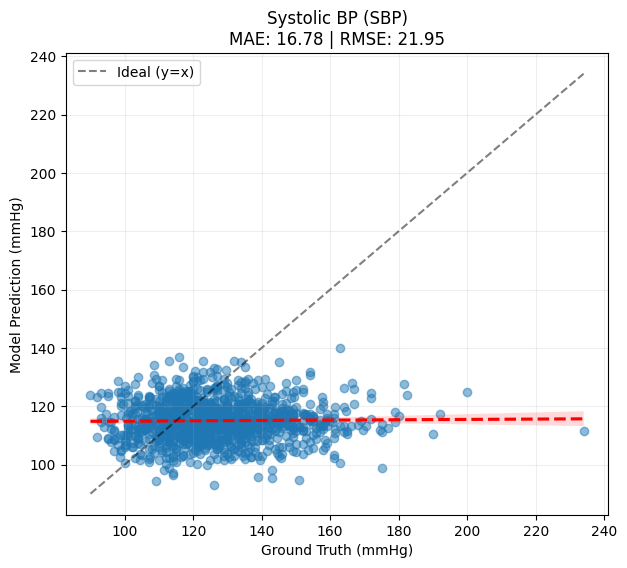

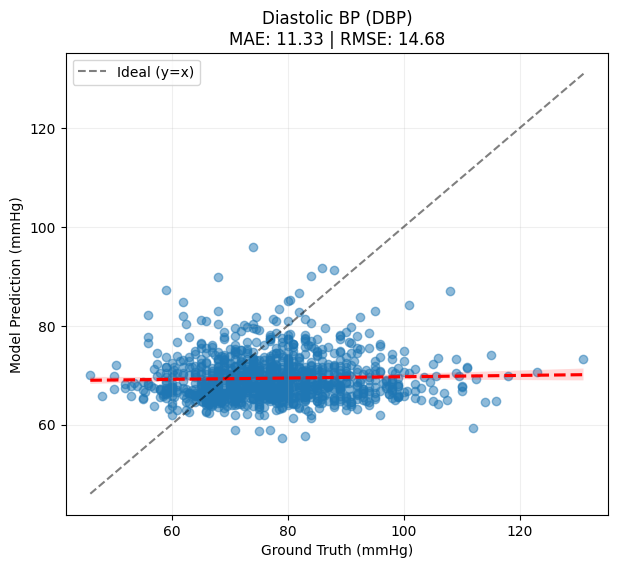

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. LOAD AND FILTER GROUND TRUTH
features_df = pd.read_table('/kaggle/input/abp-dataset/features.tsv', sep='\t')

# Filter for the specific measurement phases used in your preprocessing
# Oscillometric: Supine_2 | Auscultatory: Static_challenge_start_1
gt_osci = features_df[(features_df['pid'].str.startswith('o')) & 
                       (features_df['measurement'] == 'Supine 2')]
gt_ausc = features_df[(features_df['pid'].str.startswith('a')) & 
                       (features_df['measurement'] == 'Static challenge start 1')]

# Combine filtered ground truth
gt_df = pd.concat([gt_osci, gt_ausc])[['pid', 'sbp', 'dbp']]
gt_df.rename(columns={'pid': 'participant_id', 'sbp': 'actual_sbp', 'dbp': 'actual_dbp'}, inplace=True)

# ... (Keep Step 1: LOAD AND FILTER GROUND TRUTH as is) ...

# 2. MATCH WITH YOUR PREDICTIONS
pred_df = pd.read_csv('model_test_results.csv')
merged = pd.merge(gt_df, pred_df, on='participant_id').dropna()

# --- NEW: PRINT FIRST 10 PARTICIPANTS ---
print("="*80)
print(f"{'ID':<10} | {'Actual SBP':<10} | {'Pred SBP':<10} | {'Actual DBP':<10} | {'Pred DBP':<10}")
print("-" * 80)

# Iterate through the first 10 rows
for index, row in merged.head(10).iterrows():
    print(f"{row['participant_id']:<10} | "
          f"{row['actual_sbp']:<10.2f} | "
          f"{row['predicted_sbp']:<10.2f} | "
          f"{row['actual_dbp']:<10.2f} | "
          f"{row['predicted_dbp']:<10.2f}")
print("="*80)

# ... (Keep Step 3: PLOTTING FUNCTION as is) ...

# 3. PLOTTING FUNCTION (Predicted vs Actual with Identity Line)
def plot_regression(actual, predicted, title, color):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    plt.figure(figsize=(7, 6))
    sns.regplot(x=actual, y=predicted, scatter_kws={'alpha':0.5}, line_kws={'color':'red', 'ls':'--'})
    
    # Draw Perfect Prediction Line
    lims = [min(actual.min(), predicted.min()), max(actual.max(), predicted.max())]
    plt.plot(lims, lims, 'k--', alpha=0.5, label='Ideal (y=x)')
    
    plt.title(f"{title}\nMAE: {mae:.2f} | RMSE: {rmse:.2f}")
    plt.xlabel("Ground Truth (mmHg)")
    plt.ylabel("Model Prediction (mmHg)")
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

# Visualize results
plot_regression(merged['actual_sbp'], merged['predicted_sbp'], "Systolic BP (SBP)", "blue")
plot_regression(merged['actual_dbp'], merged['predicted_dbp'], "Diastolic BP (DBP)", "green")



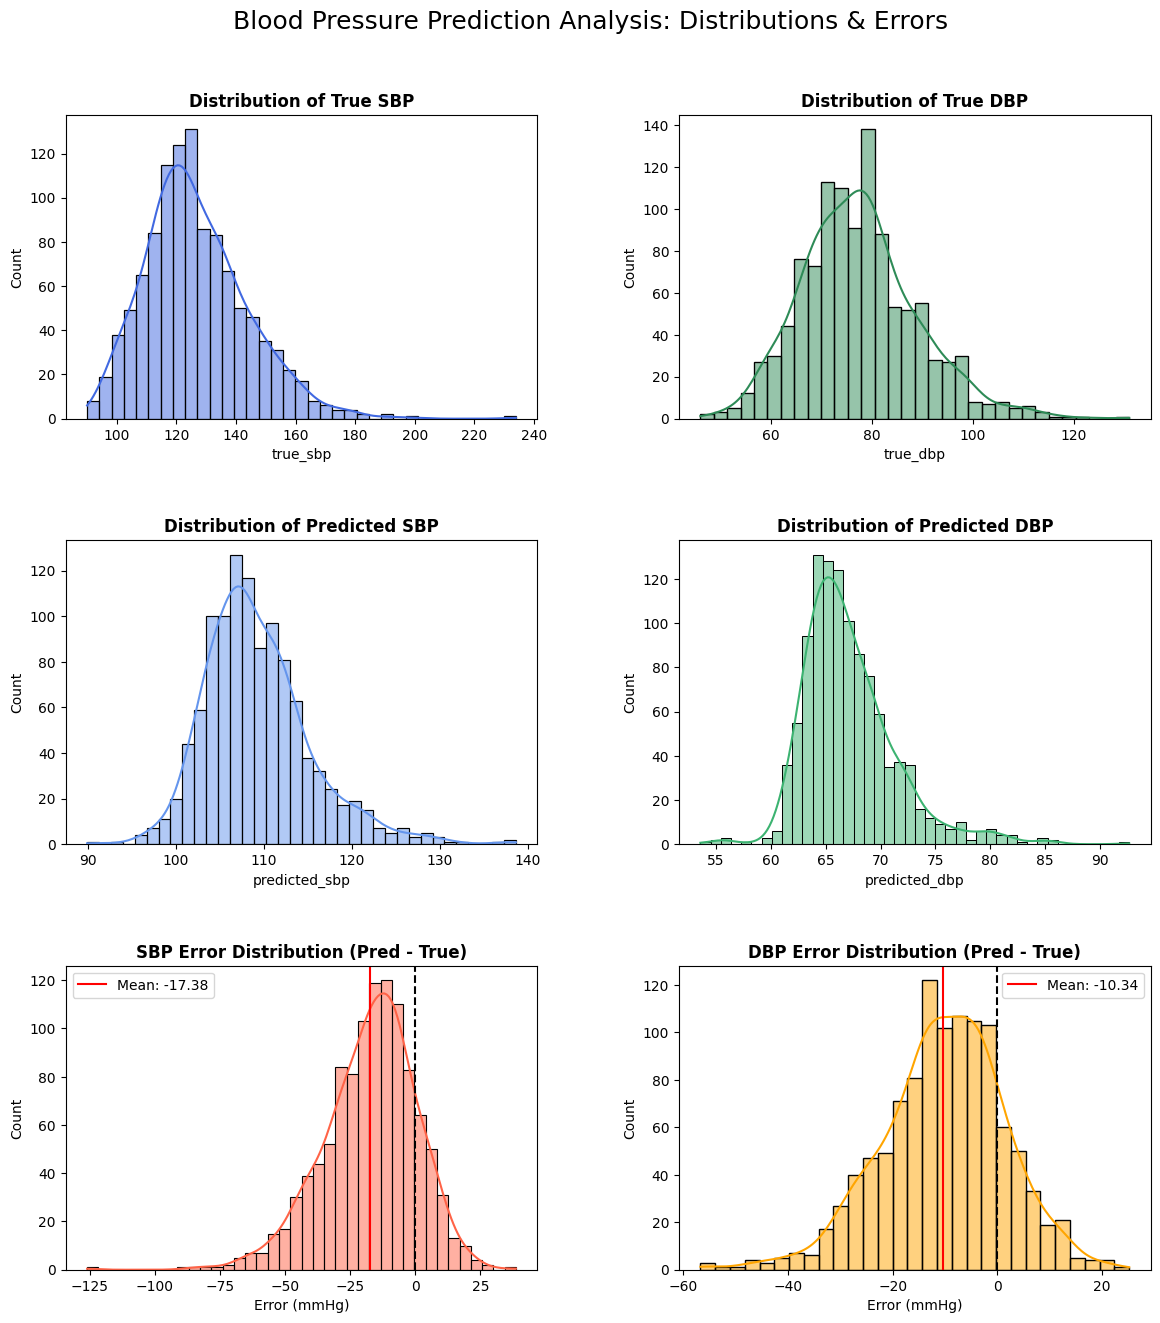

SBP Error - Mean: -17.38 mmHg, SD: 17.93 mmHg
DBP Error - Mean: -10.34 mmHg, SD: 11.90 mmHg


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# 1. LOAD AND FILTER GROUND TRUTH
features_df = pd.read_table('/kaggle/input/abp-dataset/features.tsv', sep='\t')

# Filter logic for specific phases
gt_osci = features_df[(features_df['pid'].str.startswith('o')) & 
                       (features_df['measurement'] == 'Supine 2')]
gt_ausc = features_df[(features_df['pid'].str.startswith('a')) & 
                       (features_df['measurement'] == 'Static challenge start 1')]

gt_df = pd.concat([gt_osci, gt_ausc])[['pid', 'sbp', 'dbp']]
gt_df.rename(columns={'pid': 'participant_id', 'sbp': 'true_sbp', 'dbp': 'true_dbp'}, inplace=True)
gt_df = gt_df.dropna().drop_duplicates(subset=['participant_id'])

# 2. LOAD PREDICTIONS AND MERGE
try:
    pred_df = pd.read_csv('model_test_results.csv')
    merged = pd.merge(gt_df, pred_df, on='participant_id')

    # Calculate Errors (Standard convention: Predicted - True)
    merged['sbp_error'] = merged['predicted_sbp'] - merged['true_sbp']
    merged['dbp_error'] = merged['predicted_dbp'] - merged['true_dbp']

    # 3. CREATE THE 6-PLOT VISUALIZATION
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # ROW 1: SBP & DBP TRUE DISTRIBUTIONS
    sns.histplot(merged['true_sbp'], kde=True, ax=axes[0, 0], color='royalblue')
    axes[0, 0].set_title('Distribution of True SBP', fontweight='bold')
    
    sns.histplot(merged['true_dbp'], kde=True, ax=axes[0, 1], color='seagreen')
    axes[0, 1].set_title('Distribution of True DBP', fontweight='bold')

    # ROW 2: SBP & DBP PREDICTED DISTRIBUTIONS
    sns.histplot(merged['predicted_sbp'], kde=True, ax=axes[1, 0], color='cornflowerblue')
    axes[1, 0].set_title('Distribution of Predicted SBP', fontweight='bold')

    sns.histplot(merged['predicted_dbp'], kde=True, ax=axes[1, 1], color='mediumseagreen')
    axes[1, 1].set_title('Distribution of Predicted DBP', fontweight='bold')

    # ROW 3: ERROR DISTRIBUTIONS (Predicted - True)
    # SBP Error
    sns.histplot(merged['sbp_error'], kde=True, ax=axes[2, 0], color='tomato')
    axes[2, 0].axvline(0, color='black', linestyle='--') # Zero error line
    axes[2, 0].axvline(merged['sbp_error'].mean(), color='red', label=f"Mean: {merged['sbp_error'].mean():.2f}")
    axes[2, 0].set_title('SBP Error Distribution (Pred - True)', fontweight='bold')
    axes[2, 0].set_xlabel('Error (mmHg)')
    axes[2, 0].legend()

    # DBP Error
    sns.histplot(merged['dbp_error'], kde=True, ax=axes[2, 1], color='orange')
    axes[2, 1].axvline(0, color='black', linestyle='--') # Zero error line
    axes[2, 1].axvline(merged['dbp_error'].mean(), color='red', label=f"Mean: {merged['dbp_error'].mean():.2f}")
    axes[2, 1].set_title('DBP Error Distribution (Pred - True)', fontweight='bold')
    axes[2, 1].set_xlabel('Error (mmHg)')
    axes[2, 1].legend()

    plt.suptitle('Blood Pressure Prediction Analysis: Distributions & Errors', fontsize=18, y=0.95)
    plt.savefig('full_bp_analysis.png')
    plt.show()

    # Print summary of the error
    print(f"SBP Error - Mean: {merged['sbp_error'].mean():.2f} mmHg, SD: {merged['sbp_error'].std():.2f} mmHg")
    print(f"DBP Error - Mean: {merged['dbp_error'].mean():.2f} mmHg, SD: {merged['dbp_error'].std():.2f} mmHg")

except FileNotFoundError:
    print("Error: 'model_test_results.csv' not found.")

# **Transfer learning model with label Aurora Bp**

In [20]:
import torch
import torch.nn as nn

class MuFuBPRiskClassifier(nn.Module):
    def __init__(self, pretrained_model_path):
        super(MuFuBPRiskClassifier, self).__init__()
        
        # 1. Load the full architecture
        full_model = MuFuBPNet()
        
        # 2. Load the pretrained weights
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        full_model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
        
        # 3. FREEZE all middle part weights
        # This keeps ReSE, CCFE, SCN, MoTFE, and PFE fixed
        for param in full_model.parameters():
            param.requires_grad = False
            
        # 4. Keep the backbone modules
        self.backbone = full_model 
        
        # 5. NEW ARCHITECTURE: Replace the Regressor heads with a Classifier
        # The output of the pre-predictive layer y is 16 dims
        self.risk_head = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 2) # Output 2 classes: Low Risk (0) and High Risk (1)
        )

    def forward(self, ecg, ppg):
        # Pass through frozen backbone
        # We only need the intermediate features 'y' before the SBP/DBP heads
        
        # Manually replicate the backbone forward until the regressor
        x_ecg = self.backbone.rese_ecg(ecg)
        x_ppg = self.backbone.rese_ppg(ppg)
        f_ccfe = self.backbone.ccfe(x_ecg, x_ppg)
        h_scn = self.backbone.scn(f_ccfe)
        
        xm_ecg, xt_ecg = self.backbone.motfe_ecg(ecg)
        xm_ppg, xt_ppg = self.backbone.motfe_ppg(ppg)
        
        f_msff = self.backbone.msff(h_scn, xm_ecg, xm_ppg, xt_ecg, xt_ppg)
        f_pfe, _, _ = self.backbone.pfe(f_msff)
        
        # Pre-predictive layers (Still part of the backbone, but we update the final step)
        y = torch.relu(self.backbone.fc1(f_pfe))
        y = torch.relu(self.backbone.fc2(y))
        
        # New Risk Prediction
        risk_logits = self.risk_head(y)
        return risk_logits

In [21]:
# Updated with the correct Kaggle path and filename spelling
PRETRAINED_PATH = '/kaggle/input/trained-model/mufubp_best.pth'

# Initialize the new model using the absolute path
risk_model = MuFuBPRiskClassifier(PRETRAINED_PATH).to(device)

# The rest of your code remains the same
optimizer = torch.optim.Adam(risk_model.risk_head.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [22]:
from sklearn.metrics import f1_score, accuracy_score
import torch

def train_risk_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for ecg, ppg, labels in train_loader:
        ecg, ppg, labels = ecg.to(device), ppg.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(ecg, ppg)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate Training Accuracy
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total
    return avg_loss, train_acc

def evaluate_risk_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for ecg, ppg, labels in val_loader:
            ecg, ppg, labels = ecg.to(device), ppg.to(device), labels.to(device)
            
            # Predict Risk Logits
            logits = model(ecg, ppg)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return acc, f1

In [24]:
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd

class MuFuBPDataset(Dataset):
    def __init__(self, label_csv, npz_file):
        # Load the CSV containing participant_id and risk_status
        # No header is used as per your previous file creation
        self.labels_df = pd.read_csv(label_csv, header=None, names=['pid', 'label'])
        
        # Load the compressed signal matrices created in your batch process
        self.signal_data = np.load(npz_file)
        
        # Map categorical labels to integers for the CrossEntropyLoss
        self.label_map = {'Non-Hypertensive': 0, 'Hypertensive': 1}

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        pid = self.labels_df.iloc[idx, 0]
        label_name = self.labels_df.iloc[idx, 1]
        
        # Extract the (2, 1000) matrix
        # Row 0: ECG, Row 1: PPG
        matrix = self.signal_data[pid]
        
        # Convert to tensors and add channel dimension (1, 1000)
        # The model backbone expects (Batch, 1, Length)
        ecg_tensor = torch.tensor(matrix[0], dtype=torch.float32).unsqueeze(0)
        ppg_tensor = torch.tensor(matrix[1], dtype=torch.float32).unsqueeze(0)
        
        # Get numerical label
        target = torch.tensor(self.label_map[label_name], dtype=torch.long)
        
        return ecg_tensor, ppg_tensor, target

In [25]:
from torch.utils.data import DataLoader

# 1. Initialize the Datasets using the files you created
# 'train_split.csv' contains the IDs for training
train_dataset = MuFuBPDataset('train_split.csv', 'all_participant_matrices.npz')
test_dataset = MuFuBPDataset('test_split.csv', 'all_participant_matrices.npz')

# 2. Create the DataLoaders
# Batch size 16 is recommended for this architecture
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"DataLoaders defined successfully.")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(test_dataset)}")

DataLoaders defined successfully.
Training samples: 963
Validation samples: 242


In [26]:
import pandas as pd
import numpy as np

# Load your signal archive keys
signal_data = np.load('all_participant_matrices.npz')
valid_pids = set(signal_data.keys())

def filter_csv(filename):
    # Load the CSV
    df = pd.read_csv(filename, header=None, names=['pid', 'label'])
    
    # Keep only rows where the PID exists in the NPZ archive
    df_filtered = df[df['pid'].isin(valid_pids)]
    
    # Save the cleaned version over the old one
    df_filtered.to_csv(filename, index=False, header=False)
    print(f"Cleaned {filename}: Kept {len(df_filtered)} out of {len(df)} rows.")

# Clean both files
filter_csv('train_split.csv')
filter_csv('test_split.csv')

Cleaned train_split.csv: Kept 944 out of 963 rows.
Cleaned test_split.csv: Kept 239 out of 242 rows.


In [27]:
from torch.utils.data import DataLoader

# Re-initialize the Datasets with synchronized files
train_dataset = MuFuBPDataset('train_split.csv', 'all_participant_matrices.npz')
test_dataset = MuFuBPDataset('test_split.csv', 'all_participant_matrices.npz')

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Sync complete. Training on {len(train_dataset)} participants.")
print(f"Sync complete. Training on {len(test_dataset)} participants.")

Sync complete. Training on 944 participants.
Sync complete. Training on 239 participants.


In [28]:
import torch.nn as nn

# 1. Setup Model and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
risk_model = MuFuBPRiskClassifier('/kaggle/input/trained-model/mufubp_best.pth').to(device)

# Optimization is strictly for the risk_head
optimizer = torch.optim.Adam(risk_model.risk_head.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 2. Training Loop
epochs = 30
print("Starting Training...")

for epoch in range(epochs):
    # Train step returns both loss and accuracy now
    train_loss, train_acc = train_risk_model(risk_model, train_loader, criterion, optimizer, device)
    
    # Validation/Test step remains the same
    test_acc, test_f1 = evaluate_risk_model(risk_model, test_loader, device)
    
    print(f"Epoch {epoch+1:02d} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")

print("\nTraining Finished!")

Starting Training...
Epoch 01 | Loss: 1.0814 | Train Acc: 0.5784 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 02 | Loss: 0.6918 | Train Acc: 0.6250 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 03 | Loss: 0.6578 | Train Acc: 0.6451 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 04 | Loss: 0.6553 | Train Acc: 0.6462 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 05 | Loss: 0.6533 | Train Acc: 0.6462 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 06 | Loss: 0.6556 | Train Acc: 0.6462 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 07 | Loss: 0.6539 | Train Acc: 0.6462 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 08 | Loss: 0.6529 | Train Acc: 0.6462 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 09 | Loss: 0.6539 | Train Acc: 0.6462 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 10 | Loss: 0.6515 | Train Acc: 0.6462 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 11 | Loss: 0.6521 | Train Acc: 0.6462 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 12 | Loss: 0.6532 | Train Acc: 0.6462 | Test Acc: 0.6402 | Test F1: 0.4997
Epoch 1

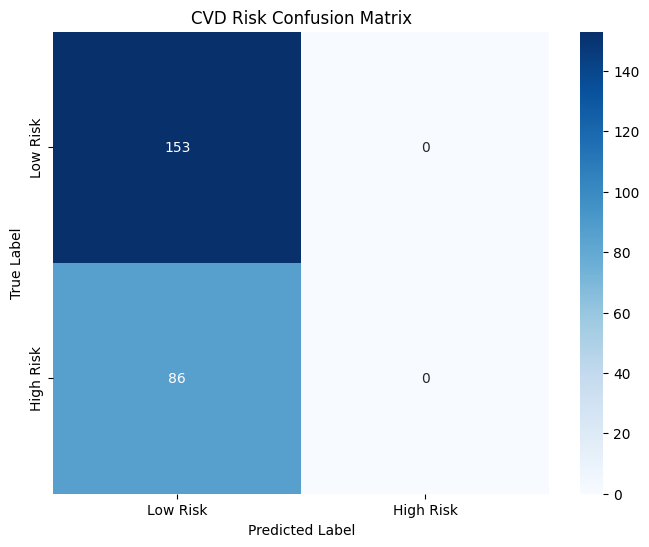

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for ecg, ppg, labels in test_loader:
            ecg, ppg, labels = ecg.to(device), ppg.to(device), labels.to(device)
            logits = model(ecg, ppg)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Generate the matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Low Risk', 'High Risk'], 
                yticklabels=['Low Risk', 'High Risk'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('CVD Risk Confusion Matrix')
    plt.show()

# Call the function after training
plot_confusion_matrix(risk_model, test_loader, device)

# **Train the model for aurorabp dataset**

In [17]:
import pandas as pd
import os

# ==========================================
# 1. LOAD AND FILTER ENTIRE DATASET
# ==========================================
features_path = '/kaggle/input/abp-dataset/features.tsv'

if os.path.exists(features_path):
    features_df = pd.read_table(features_path, sep='\t')

    # Filter for the specific baseline measurement phases for ALL participants
    # This includes both Oscillometric and Auscultatory groups
    all_gt = features_df[
        (features_df['measurement'] == 'Supine 2') | 
        (features_df['measurement'] == 'Static challenge start 1')
    ]

    # Select only the necessary columns
    final_df = all_gt[['pid', 'sbp', 'dbp']].copy()
    
    # Rename for clarity
    final_df.rename(columns={
        'pid': 'participant_id', 
        'sbp': 'actual_sbp', 
        'dbp': 'actual_dbp'
    }, inplace=True)

    # Clean up: Remove any participants with missing BP data
    final_df.dropna(subset=['actual_sbp', 'actual_dbp'], inplace=True)

    # Sort by ID to keep the file organized
    final_df = final_df.sort_values(by='participant_id')

    # ==========================================
    # 2. SAVE TO CSV
    # ==========================================
    output_filename = 'all_participants_ground_truth.csv'
    final_df.to_csv(output_filename, index=False)
    
    print(f"Success! Data for {len(final_df)} participants saved to: {output_filename}")
    print("-" * 50)
    print(final_df.head(15)) # Verification of both 'a' and 'o' IDs
    print("-" * 50)

else:
    print("Error: Could not find features.tsv. Please check the dataset path.")

Success! Data for 1123 participants saved to: all_participants_ground_truth.csv
--------------------------------------------------
      participant_id  actual_sbp  actual_dbp
27122           a000       121.0        71.0
27138           a001       140.0        90.0
27154           a002       114.0        69.0
27178           a004       114.0        67.0
27199           a005       108.0        68.0
27212           a006       154.0        78.0
27225           a007       144.0        69.0
27241           a008       126.0        92.5
27265           a009        92.0        48.0
27289           a010       121.0        79.0
27313           a011       120.0        77.0
27334           a012       125.0        86.0
27347           a013       109.0        73.0
27363           a014       131.0        82.0
27387           a017       127.0        87.0
--------------------------------------------------


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ==========================================
# 1. ReSE: Residual Self-Encoding Module
# [cite: 173] Section II.A
# ==========================================
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # "Each Ri incorporates two convolutional layers C1 and C2" [cite: 176]
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Shortcut connection Si [cite: 180]
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # [cite: 178] Ri(X) = Ni(...) + Si(X)
        out = self.relu(out)
        return out

class ReSE(nn.Module):
    def __init__(self):
        super(ReSE, self).__init__()
        # "Each block consists of three sequential residual blocks R1, R2, and R3" [cite: 175]
        # Progressively increase channels from 1 to 128
        self.block1 = ResidualBlock(1, 32, stride=2)
        self.block2 = ResidualBlock(32, 64, stride=2)
        self.block3 = ResidualBlock(64, 128, stride=2) # Final output channels = 128 [cite: 187]

    def forward(self, x):
        # Input shape: (Batch, 1, Length)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x

# ==========================================
# 2. CCFE: Cascading Cross-Feature Enhancer
# [cite: 188] Section II.B
# ==========================================
class CCFE(nn.Module):
    def __init__(self, in_channels=256): # 128 (ECG) + 128 (PPG) = 256
        super(CCFE, self).__init__()
        
        # Adaptive cSE Submodule [cite: 194]
        # C1: Channel mixing (Conv1d)
        self.c1 = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        # C2: Depth-wise convolution
        self.c2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        # C3: Point-wise convolution
        self.c3 = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.bn = nn.BatchNorm1d(in_channels)

        # Squeeze-and-Excitation Mechanism [cite: 196]
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // 16) # Reduction ratio 16 [cite: 198]
        self.fc2 = nn.Linear(in_channels // 16, in_channels)
        self.sigmoid = nn.Sigmoid()

        # Cross-Modal Layer (2 Residual Blocks) [cite: 205]
        self.res_block1 = ResidualBlock(in_channels, in_channels)
        self.res_block2 = ResidualBlock(in_channels, in_channels)

    def forward(self, x_ecg, x_ppg):
        # 1. Cross-Blend Layer (Fusion) [cite: 193]
        # Concatenate features along channel dimension
        f_cbl = torch.cat((x_ecg, x_ppg), dim=1) # Shape: (Batch, 256, L)

        # 2. Adaptive cSE [cite: 194-203]
        u1 = self.c1(f_cbl)
        u2 = self.c2(u1)
        u3 = self.c3(u2)
        u4 = self.bn(u3)

        # SE Attention
        b, c, _ = u4.size()
        z = self.global_pool(u4).view(b, c)
        z1 = F.relu(self.fc1(z))
        z2 = self.sigmoid(self.fc2(z1)).view(b, c, 1) # Broadcastable
        
        u_se = u4 * z2 # Element-wise multiplication [cite: 200]
        f_adpcse = F.relu(u_se + f_cbl) # Residual add [cite: 203]

        # 3. Cross-Modal Layer [cite: 205]
        # Two residual blocks processing the refined features
        r1 = self.res_block1(f_adpcse)
        f_ccfe = self.res_block2(r1) # [cite: 209]

        return f_ccfe

# ==========================================
# 3. SCN: Sequence Context Network
# [cite: 210] Section II.C
# ==========================================
class SCN(nn.Module):
    def __init__(self, input_size=256, hidden_size=128):
        super(SCN, self).__init__()
        # "Two layer architecture of LSTM" [cite: 213]
        # Bidirectional, so hidden_size * 2 = 256 output features
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        
    def forward(self, x):
        # x shape: (Batch, Channels, Length) -> needs (Batch, Length, Channels) for LSTM
        x = x.permute(0, 2, 1) 
        
        # LSTM output: (Batch, Length, Hidden*2)
        h_t, _ = self.lstm(x)
        
        # Global Average Pooling [cite: 216]
        # "Summarize features... into a single feature vector"
        h_scn_gap = torch.mean(h_t, dim=1) # Shape: (Batch, 256)
        return h_scn_gap

# ==========================================
# 4. MoTFE: Morphological & Temporal Feature Extractor
# [cite: 220] Section II.D
# ==========================================
class MoTFE(nn.Module):
    def __init__(self):
        super(MoTFE, self).__init__()
        
        # Morphological Feature Extractor (MFE) [cite: 222]
        # Conv -> ReLU -> AdaptiveAvgPool -> 32 dims
        self.mfe_conv = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.mfe_pool = nn.AdaptiveAvgPool1d(1) # Produces vector of size 32
        
        # Temporal Feature Extractor (TFE) [cite: 234]
        # Conv -> ReLU -> AdaptiveMaxPool -> 32 dims
        self.tfe_conv = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.tfe_pool = nn.AdaptiveMaxPool1d(1) # Produces vector of size 32

    def forward(self, x):
        # x is raw signal: (Batch, 1, Length)
        
        # Morphological path
        m = F.relu(self.mfe_conv(x))
        x_m = self.mfe_pool(m).view(x.size(0), -1) # Flatten to (Batch, 32)
        
        # Temporal path
        t = F.relu(self.tfe_conv(x))
        x_t = self.tfe_pool(t).view(x.size(0), -1) # Flatten to (Batch, 32)
        
        return x_m, x_t

# ==========================================
# 5. MsFF: Multi-Scale Feature Fusion
# [cite: 262] Section II.E
# ==========================================
class MsFF(nn.Module):
    def __init__(self):
        super(MsFF, self).__init__()
        # Purely structural fusion, no learnable weights in this specific block [cite: 264]
        
    def forward(self, h_scn, xm_ecg, xm_ppg, xt_ecg, xt_ppg):
        # Equation (16): Concatenate all feature vectors along dimension 1 [cite: 264]
        # F_MsFF = [H_SCN, X_M_ECG, X_M_PPG, X_T_ECG, X_T_PPG]
        f_msff = torch.cat((h_scn, xm_ecg, xm_ppg, xt_ecg, xt_ppg), dim=1) 
        
        # Output shape: 256 + 32 + 32 + 32 + 32 = 384
        return f_msff

# ==========================================
# 6. Probabilistic Feature Encoder (PFE)
# [cite: 266] Section II.F
# ==========================================
class PFE(nn.Module):
    def __init__(self, input_dim=384, latent_dim=64):
        super(PFE, self).__init__()
        # Shared encoder part (phi)
        self.fc_shared = nn.Linear(input_dim, 256)
        
        # Mean vector mu [cite: 269]
        self.fc_mu = nn.Linear(256, latent_dim)
        
        # Log variance log_sigma^2 [cite: 269]
        self.fc_logvar = nn.Linear(256, latent_dim)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick [cite: 270]
        # z = mu + sigma * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = F.relu(self.fc_shared(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        z = self.reparameterize(mu, logvar) # Latent variable F_PFE
        return z, mu, logvar

# ==========================================
# MAIN MODEL: MuFuBP-Net
# ==========================================
class MuFuBPNet(nn.Module):
    def __init__(self):
        super(MuFuBPNet, self).__init__()
        
        # 1. ReSE Modules (Dual Pipeline) [cite: 174]
        self.rese_ecg = ReSE()
        self.rese_ppg = ReSE()
        
        # 2. CCFE Module [cite: 192]
        self.ccfe = CCFE(in_channels=256)
        
        # 3. SCN Module [cite: 210]
        self.scn = SCN(input_size=256)
        
        # 4. MoTFE Modules (Dual Pipeline) [cite: 220]
        self.motfe_ecg = MoTFE()
        self.motfe_ppg = MoTFE()
        
        # 5. MsFF Module [cite: 263]
        self.msff = MsFF()
        
        # 6. PFE Module (Latent Space) [cite: 267]
        # Input to PFE is 384 dims
        # 256 (SCN) + 32 (M_ECG) + 32 (T_ECG) + 32 (M_PPG) + 32 (T_PPG) = 384
        self.pfe = PFE(input_dim=384, latent_dim=64)
        
        # 7. Pre-Predictive Layers (Regressor) [cite: 245]
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        
        # Final Output Heads [cite: 251]
        self.head_sbp = nn.Linear(16, 1)
        self.head_dbp = nn.Linear(16, 1)

    def forward(self, ecg, ppg):
        # ecg, ppg shapes: (Batch, 1, Length)
        
        # --- Hierarchical Features Pipeline ---
        x_ecg = self.rese_ecg(ecg) # -> (B, 128, L')
        x_ppg = self.rese_ppg(ppg) # -> (B, 128, L')
        
        f_ccfe = self.ccfe(x_ecg, x_ppg) # -> (B, 256, L')
        h_scn = self.scn(f_ccfe)         # -> (B, 256) [Vector]
        
        # --- Modality Features Pipeline (MoTFE) ---
        xm_ecg, xt_ecg = self.motfe_ecg(ecg) # -> (B, 32), (B, 32)
        xm_ppg, xt_ppg = self.motfe_ppg(ppg) # -> (B, 32), (B, 32)
        
        # --- Multi-scale Feature Fusion (MsFF) ---
        # Explicitly calling the MsFF module
        f_msff = self.msff(h_scn, xm_ecg, xm_ppg, xt_ecg, xt_ppg) # -> (B, 384)
        
        # --- Probabilistic Feature Encoder (PFE) ---
        f_pfe, mu, logvar = self.pfe(f_msff) # -> (B, 64)
        
        # --- Pre-Predictive Layers ---
        y = F.relu(self.fc1(f_pfe))
        y = F.relu(self.fc2(y))
        
        sbp = self.head_sbp(y)
        dbp = self.head_dbp(y)
        
        return sbp, dbp, mu, logvar

# ==========================================
# TEST RUN
# ==========================================
if __name__ == "__main__":
    # Simulate input: Batch size 16, 1 Channel, 1000 samples (8 seconds @ 125Hz)
    dummy_ecg = torch.randn(16, 1, 1000)
    dummy_ppg = torch.randn(16, 1, 1000)
    
    model = MuFuBPNet()
    
    sbp_pred, dbp_pred, mu, logvar = model(dummy_ecg, dummy_ppg)
    
    print("Model Architecture Loaded Successfully.")
    print(f"Input Shape: {dummy_ecg.shape}")
    print(f"SBP Output Shape: {sbp_pred.shape}") # Should be (16, 1)
    print(f"DBP Output Shape: {dbp_pred.shape}") # Should be (16, 1)
    print(f"Latent Mu Shape: {mu.shape}")       # Should be (16, 64)

Model Architecture Loaded Successfully.
Input Shape: torch.Size([16, 1, 1000])
SBP Output Shape: torch.Size([16, 1])
DBP Output Shape: torch.Size([16, 1])
Latent Mu Shape: torch.Size([16, 64])


Starting Training...
Epoch 1/200, Loss: 19011.7256
Epoch 10/200, Loss: 433.7496
Epoch 20/200, Loss: 349.6906
Epoch 30/200, Loss: 339.8108
Epoch 40/200, Loss: 279.6373
Epoch 50/200, Loss: 264.4119
Epoch 60/200, Loss: 173.0395
Epoch 70/200, Loss: 127.2310
Epoch 80/200, Loss: 106.1828
Epoch 90/200, Loss: 101.6723
Epoch 100/200, Loss: 84.2714
Epoch 110/200, Loss: 76.9786
Epoch 120/200, Loss: 68.9035
Epoch 130/200, Loss: 68.4431
Epoch 140/200, Loss: 66.0423
Epoch 150/200, Loss: 82.6138
Epoch 160/200, Loss: 58.8102
Epoch 170/200, Loss: 61.8180
Epoch 180/200, Loss: 60.0390
Epoch 190/200, Loss: 61.6618
Epoch 200/200, Loss: 62.5882

Mean Absolute Error SBP: 13.87 mmHg
Mean Absolute Error DBP: 10.26 mmHg

Correlation plots saved as 'sbp_correlation.png' and 'dbp_correlation.png'.


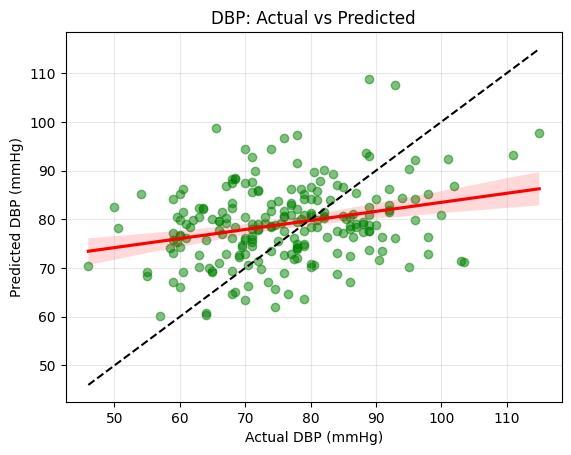

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ==========================================
# 2. Dataset and Loss Function
# ==========================================

class BpDataset(Dataset):
    def __init__(self, npz_path, csv_path):
        self.signals = np.load(npz_path)
        self.labels_df = pd.read_csv(csv_path)
        id_col = 'id' if 'id' in self.labels_df.columns else self.labels_df.columns[0]
        valid_indices = []
        for idx, row in self.labels_df.iterrows():
            key = str(row[id_col])
            if key in self.signals:
                valid_indices.append(idx)
        self.filtered_labels = self.labels_df.iloc[valid_indices].reset_index(drop=True)
        self.keys = self.filtered_labels[id_col].values

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = str(self.keys[idx])
        data = self.signals[key].astype(np.float32)
        ecg = data[:, 0:1].T 
        ppg = data[:, 1:2].T
        sbp = self.filtered_labels.iloc[idx]['actual_sbp']
        dbp = self.filtered_labels.iloc[idx]['actual_dbp']
        return torch.from_numpy(ecg), torch.from_numpy(ppg), torch.tensor([sbp], dtype=torch.float32), torch.tensor([dbp], dtype=torch.float32)

def mufubp_loss(sbp_pred, sbp_true, dbp_pred, dbp_true, mu, logvar, kld_weight=0.01):
    loss_sbp = F.mse_loss(sbp_pred, sbp_true)
    loss_dbp = F.mse_loss(dbp_pred, dbp_true)
    kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return loss_sbp + loss_dbp + (kld_weight * kld_loss)

# ==========================================
# 3. Plotting Function
# ==========================================

def plot_correlation(true_vals, pred_vals, label, filename, color):
    plt.clf()
    sns.regplot(x=true_vals, y=pred_vals, scatter_kws={'alpha':0.5, 'color':color}, line_kws={'color':'red'})
    plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], color='black', linestyle='--')
    plt.title(f'{label}: Actual vs Predicted')
    plt.xlabel(f'Actual {label} (mmHg)')
    plt.ylabel(f'Predicted {label} (mmHg)')
    plt.grid(True, alpha=0.3)
    plt.savefig(filename)

# ==========================================
# 4. Training and Testing Loop
# ==========================================

def train_and_test_model():
    npz_path = '/kaggle/working/all_participant_matrices.npz'
    csv_path = '/kaggle/working/all_participants_ground_truth.csv'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size, lr, epochs = 32, 0.001, 200

    dataset = BpDataset(npz_path, csv_path)
    train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

    model = MuFuBPNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("Starting Training...")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for ecg, ppg, sbp_true, dbp_true in train_loader:
            ecg, ppg = ecg.to(device), ppg.to(device)
            sbp_true, dbp_true = sbp_true.to(device), dbp_true.to(device)
            optimizer.zero_grad()
            sbp_pred, dbp_pred, mu, logvar = model(ecg, ppg)
            loss = mufubp_loss(sbp_pred, sbp_true, dbp_pred, dbp_true, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

    # Testing Phase
    model.eval()
    all_sbp_true, all_sbp_pred = [], []
    all_dbp_true, all_dbp_pred = [], []

    with torch.no_grad():
        for ecg, ppg, sbp_true, dbp_true in test_loader:
            ecg, ppg = ecg.to(device), ppg.to(device)
            sbp_pred, dbp_pred, _, _ = model(ecg, ppg)
            all_sbp_true.extend(sbp_true.numpy().flatten())
            all_sbp_pred.extend(sbp_pred.cpu().numpy().flatten())
            all_dbp_true.extend(dbp_true.numpy().flatten())
            all_dbp_pred.extend(dbp_pred.cpu().numpy().flatten())

    # Calculate MAE
    mae_sbp = np.mean(np.abs(np.array(all_sbp_true) - np.array(all_sbp_pred)))
    mae_dbp = np.mean(np.abs(np.array(all_dbp_true) - np.array(all_dbp_pred)))
    print(f"\nMean Absolute Error SBP: {mae_sbp:.2f} mmHg")
    print(f"Mean Absolute Error DBP: {mae_dbp:.2f} mmHg")

    # Generate Plots
    plot_correlation(all_sbp_true, all_sbp_pred, 'SBP', 'sbp_correlation.png', 'blue')
    plot_correlation(all_dbp_true, all_dbp_pred, 'DBP', 'dbp_correlation.png', 'green')
    print("\nCorrelation plots saved as 'sbp_correlation.png' and 'dbp_correlation.png'.")

# Execute
train_and_test_model()